In [1116]:
import os
import sys

import pandas as pd
import numpy as np

from sklearn.preprocessing import normalize, scale
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from collections import OrderedDict

from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene

from scipy.sparse import csr_matrix
from scipy.io import mmread, mmwrite
from scipy import stats


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15


alpha = 0.33

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [853]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {
    "cell": cividis(0.01),
    "gene": cividis(0.5),
    "mono": cividis(0.99)
}

In [1052]:
#@title mx diff

from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import pandas as pd
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

import numpy as np
from statsmodels.stats.multitest import multipletests

def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """

    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, nfeat, method):
    if method == 'bonferroni':
        pval_corr = np.minimum(pval*nfeat[:,None], 1.0)
    return pval_corr

def nd(arr):
    return np.asarray(arr).reshape(-1)
def correct_pvals(pvals):
    r = np.empty(np.shape(pvals))
    r[:] = np.nan
    for pidx, p in enumerate(pvals):
        mask = ~np.isnan(p)


    return r


def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    es = np.empty((nuniq, nfeat)) # unique assignments by features 
    nfeatures = np.empty((nuniq))
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)
    es.fill(np.nan)
    nfeatures.fill(np.nan)
    

    for tidx, t in enumerate(unique):
        logging.info("{} of {} assignments: {}".format(tidx+1, nuniq, t))

        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        pvalue = np.nan
        statistic = np.nan
        effect_size = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        t_mat = t_mat[:, mask]
        c_mat = c_mat[:, mask]
        # added

        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate", equal_var=False)
            pvalue = test.pvalue
            statistic = test.statistic
            effect_size = nd(t_mat.mean(axis=0)) - nd(c_mat.mean(axis=0))
            nfeatures[tidx] = mask.sum()

        pval[tidx,:][mask] = pvalue
        stat[tidx,:][mask] = statistic
        es[tidx,:][mask] = effect_size
    return (pval, stat, es, nfeatures)

def make_table(assignments, features, p_raw, p_corr, es):
    unique = np.unique(assignments)
    markers = pd.DataFrame(index=unique, columns=["name", "p_raw", "p_corr", "es"])

    for uidx, u in enumerate(unique):
        markers.loc[u]["name"] = features
        markers.loc[u]["p_raw"] = p_raw[uidx]
        markers.loc[u]["p_corr"] = p_corr[uidx]
        markers.loc[u]["es"] = es[uidx]

    markers = markers.apply(pd.Series.explode).reset_index()
    markers = markers[markers.notnull()["p_raw"]]
    markers = markers.rename(columns={"index": "group_id"})
    return markers

def diff(mat, components, features, assignments):

    unique = np.unique(assignments)
    nan_cutoff = 0.1 # of elements in cluster
    corr_method = "bonferroni"


    p_raw, stat, es, nfeat = dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
    p_raw = p_raw/2
    p_corr = correct_pval(p_raw, nfeat, corr_method)

    s = stat

    markers_gene = make_table(assignments, features, p_raw, p_corr, es)

    # convert the 0 pvalues to the smallest possible float
    markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
    # markers_gene = markers_gene.query("es > 0")
    return markers_gene

In [1234]:
def get_min_diff(matrix):
    x = matrix.flatten()
    xs = np.sort(x)
    b = xs[0]
    mn = 1100.
    for i in range(1, xs.shape[0]):
        a = xs[i]
        if a == b:
            continue

        diff = abs(a-b)
        if diff < mn and diff > 0:
            mn = diff
        b = a
    return mn

def mono(matrix, raw):
    rv = np.zeros(matrix.shape[0])
    for i in range(matrix.shape[0]):
        r, p  = stats.spearmanr(matrix[i], raw[i])
        rv[i] = r
    return rv

def plot_meanvar(mtx, raw_mean, minlim = 1e-4, maxlim = 1e5, ax=None):
    p = {
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
        "xlim": (minlim, maxlim),
    }
    
    gvar = np.var(mtx, axis=0)
    gcov = np.sqrt(np.var(gvar))/np.mean(gvar)

    y = np.var(mtx, axis=0)
    yy = (y-y.mean())/np.sqrt(np.var(y))

    ax.scatter(raw_mean, y, facecolor=colors["gene"], alpha=alpha, edgecolor="k", label=f"CoV: {gcov:,.1f}")
    ax.legend(prop={"size": 12})
    ax.set(**p)
    yex(ax)
    return ax

def plot_depth(mtx, raw_cell_counts, ax):
    x = raw_cell_counts
    y = np.sum(mtx, axis=1)
    
    minx, maxx = min(x), max(x)
    miny, maxy = min(y), max(y)
    maxy = maxy - miny

    xx = (x - minx)/maxx
    yy = (y - miny)/maxy
    
    close = np.all(np.allclose(y, y[0]))
    if close:
        yy = [1]*len(y)
    ax.scatter(xx,yy, edgecolor="k", facecolor=colors["cell"], alpha=alpha)
        
    reg = LinearRegression().fit(xx.reshape(-1,1), yy)
    r2 = reg.score(xx.reshape(-1,1), yy)

    if close:
        # handle the degenerate case where the slope is 0 since all values y are same
        r2 = 0
    
    xxx = np.array([min(xx), max(xx)])

    ax.plot(xxx, reg.coef_*xxx+ reg.intercept_, color="darkgray", linestyle="--", label=f"r$^2$: {r2:,.2f}", linewidth=3)
    

    p = {
      "xlabel": "Raw cell count",
      "ylabel": "Transform cell count",
      "xlim": (-0.1, 1.1),
      "ylim": (-0.1, 1.1),
    }
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

def plot_mono(matrix, raw, ax):
    x = mono(matrix, raw)
    p = {
        "xlabel": "Spearman r",
        "ylabel": "Frequency",
        "xlim": (-0.1, 1.2)
    }
    close = np.all(np.allclose(x, x[0]))
    if close:
        weights=np.ones(len(x)) / len(x)
        x = np.array([1] * len(x))
        ax.hist(x, facecolor=colors["mono"], edgecolor="k", weights=weights)
    else:
        weights=np.ones(len(x)) / len(x)
        ax.hist(x, facecolor=colors["mono"], weights=weights, edgecolor="k")
    ax.axvline(x.mean(), linestyle="--", color="darkgray", label=f"mean: {x.mean():,.2f}")
    ax.set(**p)
    ax.legend(prop={"size": 12})
    return ax

In [1214]:
[i["cov_gene_var"] for k, i in metrics.items()]

[98.79943748998488,
 72.84626230508171,
 3.411363542633603,
 3.0444778212831034,
 3.966493658868138,
 1.677016013895201,
 1.9158488718930984,
 12.494603337421534,
 0.6360411320622211,
 2.2435051223306125e-13]

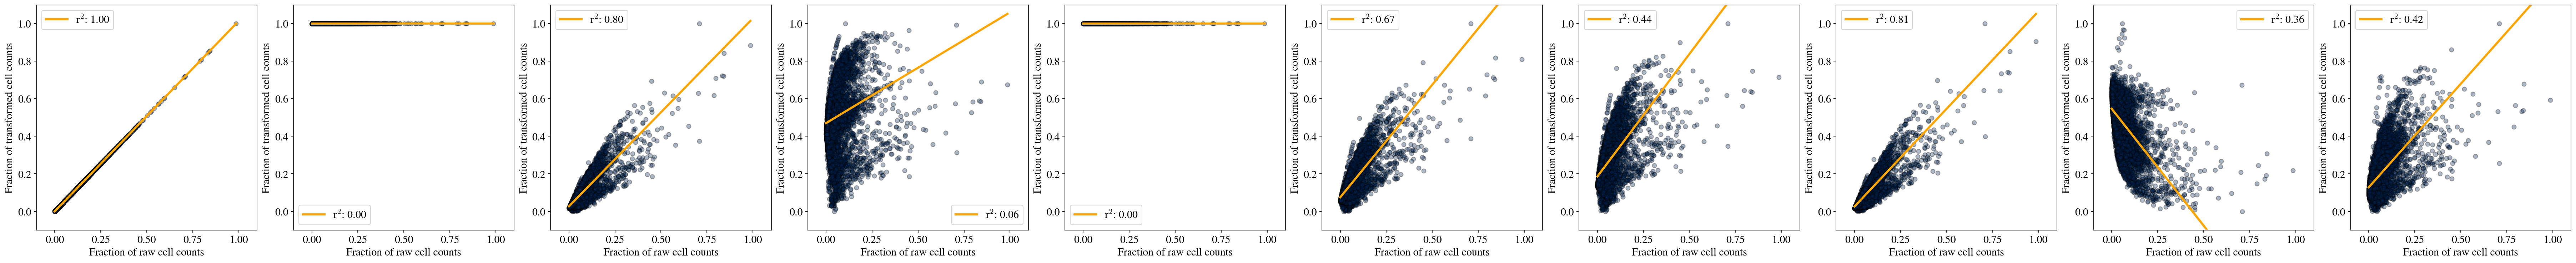

In [1210]:
nc = len(labels)
fig, axs = plt.subplots(figsize=(5*nc,5), ncols=nc, constrained_layout=True)

for ax, (k,v) in zip(axs, data.items()):
    plot_depth(v, data["raw"].sum(1), ax)

fig.show()

In [1181]:
data.keys()

dict_keys(['raw', 'pf', 'log', 'pf_log', 'pf_log_pf', 'cpm_log', 'cp10k_log', 'sqrt', 'sctransform', 'cp10k_log_scale'])

[('raw', 810.9132396181335),
 ('pf', 1.6054937599261305e-13),
 ('log', 268.7136706063397),
 ('pf_log', 80.1731482024945),
 ('pf_log_pf', 6.895203354436059e-14),
 ('cpm_log', 1680.7470973138038),
 ('cp10k_log', 437.3221071181672),
 ('sqrt', 371.7497609327776),
 ('sctransform', 518.2166021361654),
 ('cp10k_log_scale', 915.2795383407113)]

In [3]:
read_labels = ['raw', 'pf', 'log', 'pf_log', 'pf_log_pf', 'cpm_log', 'cp10k_log', "sqrt"]
labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']

In [4]:
def read_data(base_data_fn):
    data = {}

    for title in read_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx")
        data[title] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv")
    data[title] = pd.read_csv(in_fn, header=None).values
    return data

In [5]:
ds = "angelidis_2019"
out_prefix =  os.path.join("synchromesh/data/", ds)

In [ ]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform


In [ ]:
bcs = pd.read_csv(os.path.join(out_prefix, "metadata_barcodes.txt"), index_col=0)
assignments = bcs.celltype.values
    
genes = []
read_str_list(os.path.join(out_prefix, "raw_genes.txt"), genes)
genes = np.array(genes)

# Comparison

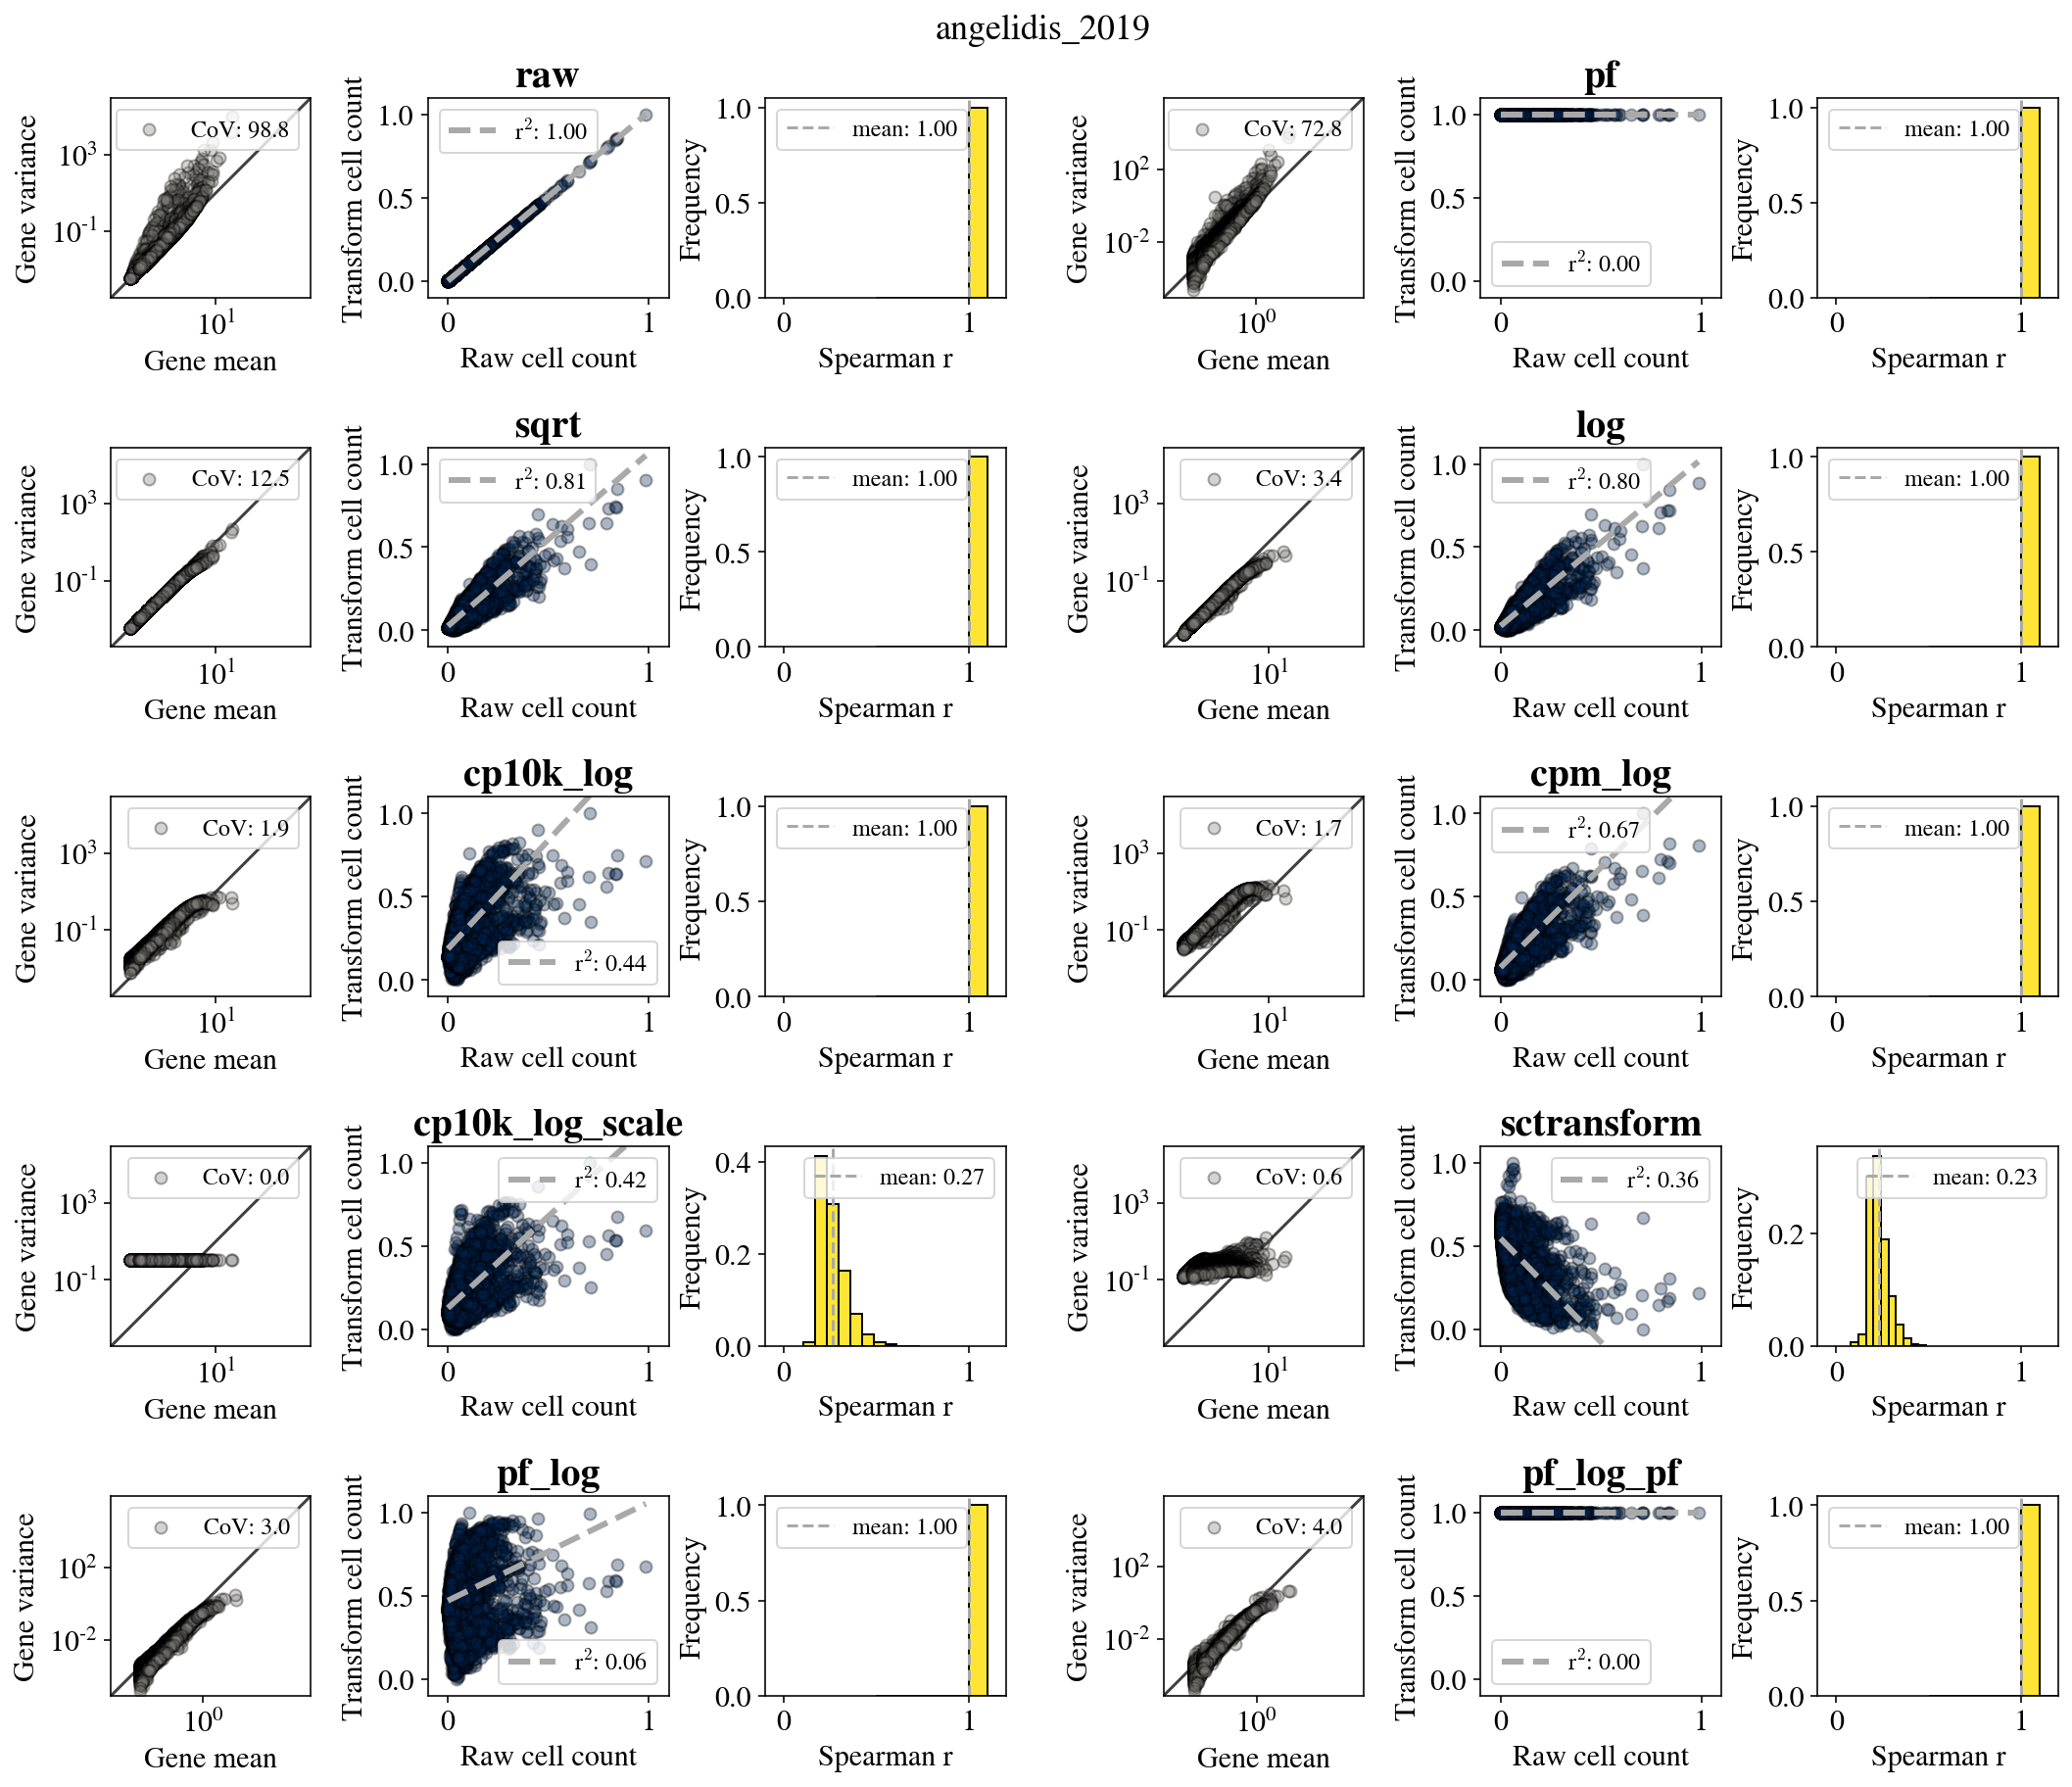

In [1235]:
fig = plt.figure(figsize=(6*3,5*3))
fig.suptitle(ds, y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.75)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i,j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

raw = data["raw"]

minlim = min(np.min(np.var(raw, 0)), np.min(np.mean(raw, 0))) * 0.1
maxlim = max(np.max(np.var(raw, 0)), np.max(np.mean(raw, 0))) * 10
for (ax1, ax2, ax3), title in zip(axs, labels):
    m = data[title]
    plot_meanvar(m, raw.mean(0), minlim = minlim, maxlim = maxlim, ax=ax1)
    plot_depth(m, raw.sum(1), ax2)
    plot_mono(m, raw, ax3)
    ax2.set_title(title, fontsize=20, weight="bold")

fig.savefig(f"{ds}_methods_metrics.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

In [ ]:
def pairwise_spearman(X, mn=0):
    # break ties 
    mns = np.random.uniform(-mn/4, mn/4, size=X.shape[1])
    X = X.astype(float) + mns
    corr = stats.spearmanr(X, axis=1).correlation
    corr = corr[np.triu_indices(corr.shape[0], k=1)]
    return corr

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [18]:
%%time
mins = {}
for l in labels:
    mins[l] = get_min_diff(data[l])
mins

CPU times: user 7min 18s, sys: 11.3 s, total: 7min 30s
Wall time: 7min 30s


{'raw': 1,
 'pf': 5.551115123125783e-17,
 'sqrt': 0.008884064315125784,
 'log': 0.0003156067566045806,
 'cp10k_log': 6.107294758805892e-07,
 'cpm_log': 6.108287102790655e-07,
 'cp10k_log_scale': 5.992983886926595e-13,
 'sctransform': 1.942890293094024e-16,
 'pf_log': 1.1102230246251565e-16,
 'pf_log_pf': 2.882971639195375e-10}

In [910]:
#metrics = {}
for k, m in data.items():
    print(k)
    gvar = np.var(m, axis=0)
    gmean = np.mean(m, axis=0)
    cellsum = np.sum(m, axis=1)
    depth_pearson, _ = stats.pearsonr(data["raw"].sum(1), cellsum)
    
    cutoff = 0.2
    metrics[k] = {
        "cov_gene_var": np.sqrt(np.var(gvar))/np.mean(gvar),
        "cov_gene_var_mean_upper": np.sqrt(np.var(gvar[gmean >= cutoff]))/np.mean(gvar[gmean >= cutoff]),
        "cov_gene_var_mean_lower": np.sqrt(np.var(gvar[gmean < cutoff]))/np.mean(gvar[gmean < cutoff]),
        "mono": mono(m, data["raw"]).mean(),
        "depth_pearson": depth_pearson,
        "cov_cell_depth": np.sqrt(np.var(cellsum)) / np.mean(cellsum)
    }

raw
pf
log
pf_log
pf_log_pf
cpm_log
cp10k_log
sqrt
sctransform
cp10k_log_scale


In [1188]:
[(k, i["cov_cell_depth"]) for k, i in metrics.items()]

[('raw', 0.990769672107577),
 ('pf', 1.961584110825267e-16),
 ('log', 0.7276646671264669),
 ('pf_log', 0.2164986206440084),
 ('pf_log_pf', 1.8619725541087078e-16),
 ('cpm_log', 0.523226607648556),
 ('cp10k_log', 0.36324585930806086),
 ('sqrt', 0.7166784470547205),
 ('sctransform', -0.4796266200952659),
 ('cp10k_log_scale', -2531796537616785.0)]

In [ ]:
# bar graph on cov_cell_depth without sctransform and cpls

In [911]:
[(i, metrics[i]["depth_pearson"]) for i in metrics.keys()]

[('raw', 1.0),
 ('pf', 6.879823486461385e-07),
 ('log', 0.7966636224242475),
 ('pf_log', 0.05711143254189563),
 ('pf_log_pf', 1.2574860297694354e-05),
 ('cpm_log', 0.6720563235426532),
 ('cp10k_log', 0.4350416422190814),
 ('sqrt', 0.8119311150198034),
 ('sctransform', 0.3605874637890887),
 ('cp10k_log_scale', 0.42273103194745976)]

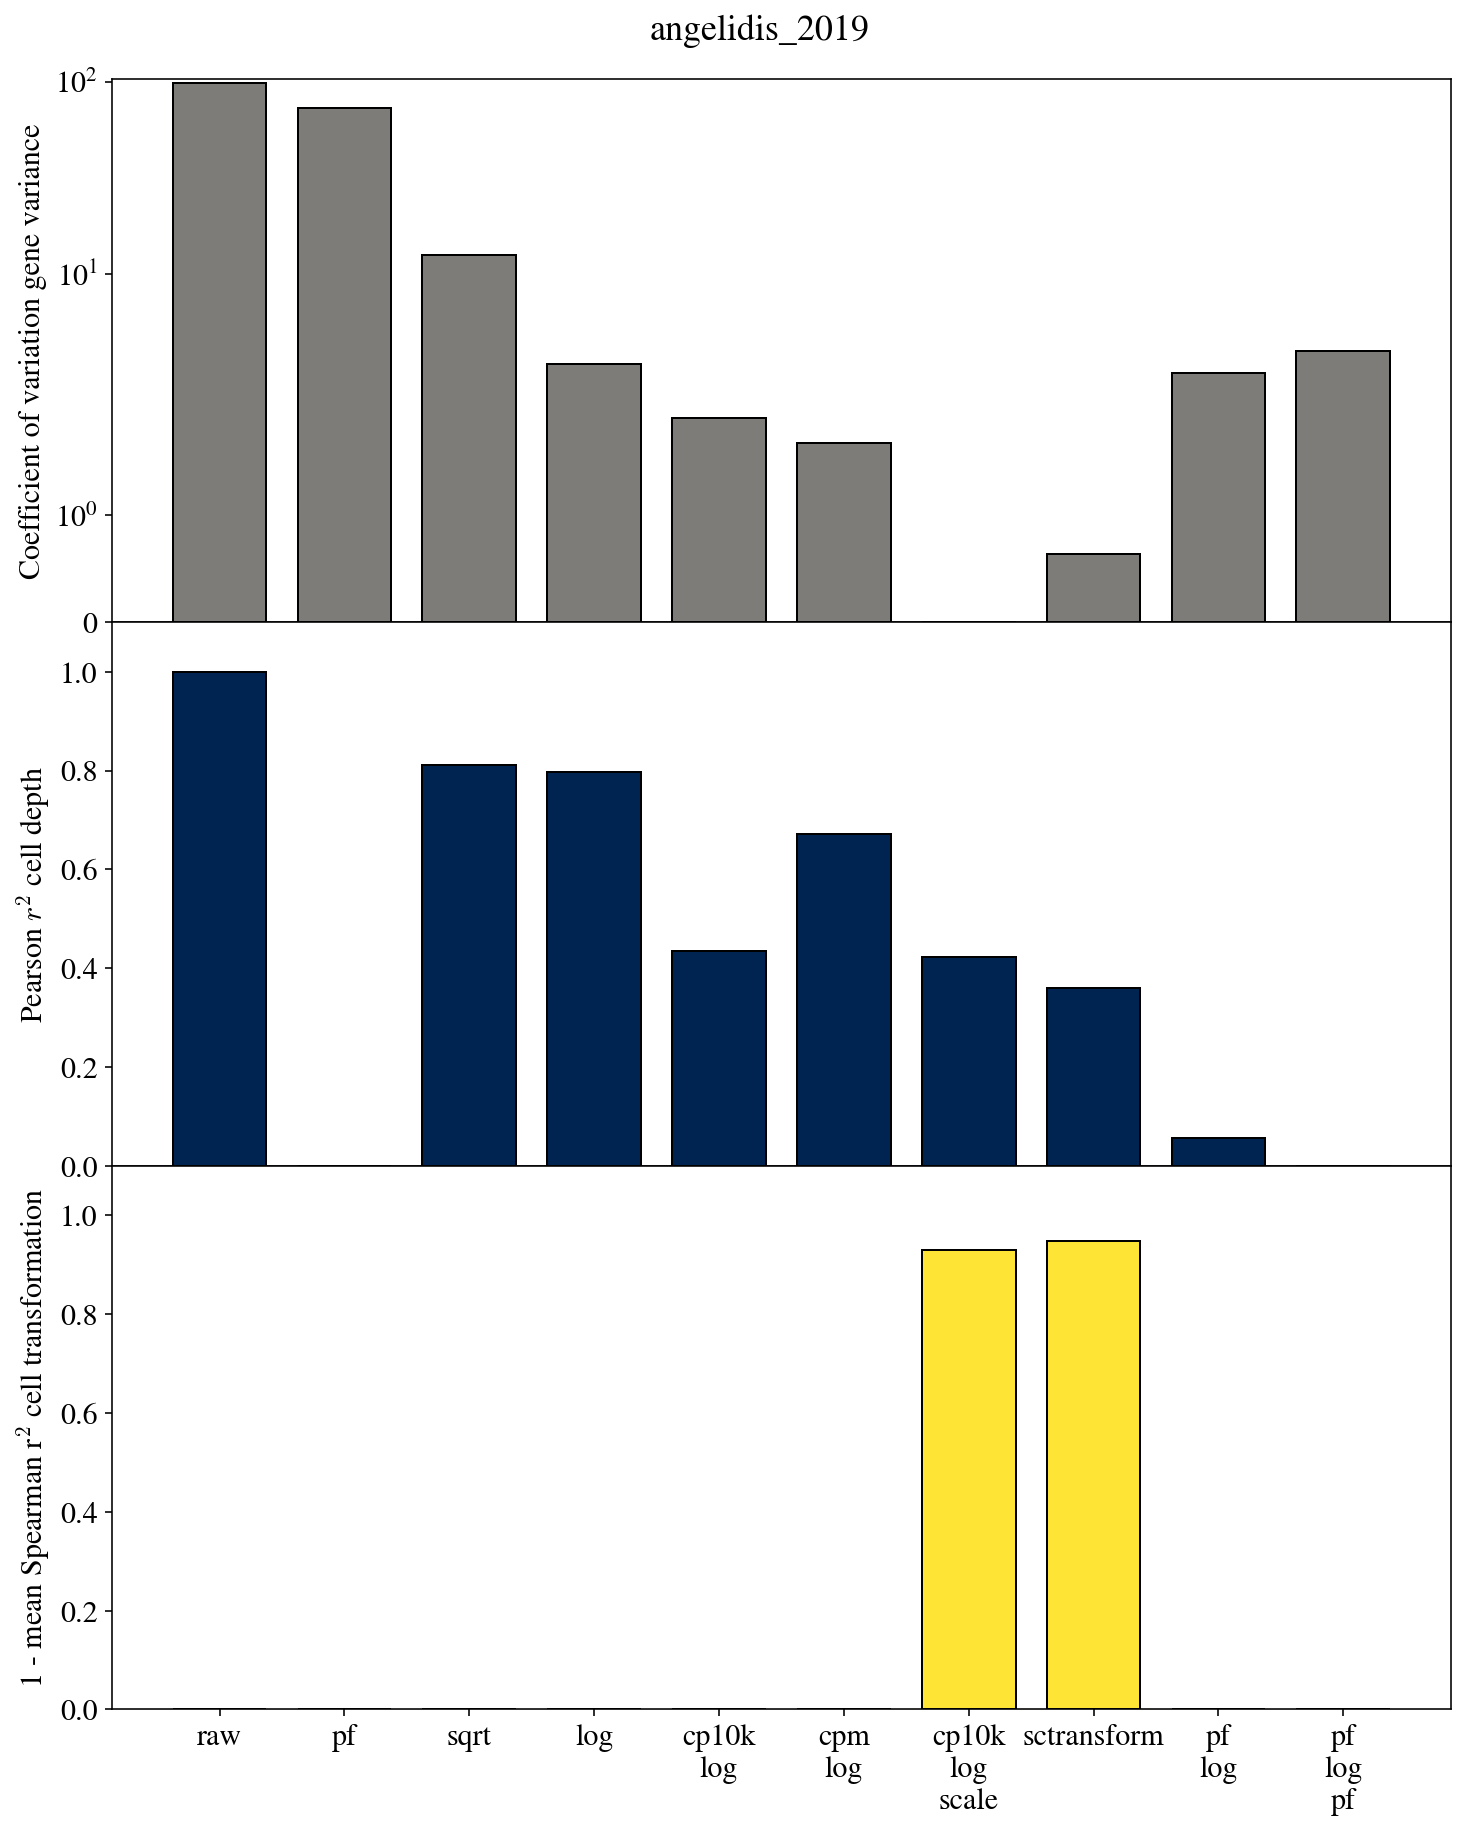

In [1064]:
nr=3

fig, axs = plt.subplots(figsize=(12,5*nr), nrows=nr)
fig.suptitle(ds, y=0.91)
fig.subplots_adjust(hspace=0)

x = ["\n".join(i.split("_")) for i in labels]
xx = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

p = {
    "xticks": [],
    "xticklabels": []

}

##################
ax = axs[0]

y = np.array([metrics[i]["cov_gene_var"] for i in labels])
ax.bar(xx, y, width, label='Gene variance', edgecolor="k", color=colors["gene"])

p.update({
    "ylim": 0,
    "yscale" : "symlog",
    "ylabel": "Coefficient of variation gene variance"
})

ax.set(**p)

##################
ax = axs[1]

y = np.array([metrics[i]["depth_pearson"] for i in labels])
ax.bar(xx, y**2, width, label='Cell depth', edgecolor="k", color=colors["cell"])

p.update({
    "ylabel": "Pearson $r^2$ cell depth",
    "yscale": "linear",
    "ylim": (0,1.1)
})

ax.set(**p)


##################
ax = axs[2]

y = np.array([metrics[i]["mono"] for i in labels])
ax.bar(xx, 1 - y**2, width, label='Monotonicity', edgecolor="k", color=colors["mono"])

p.update({
    "yscale": "linear",
    "xticks": xx,
    "xticklabels": x,
    "ylim": (0, 1.1),
    "ylabel": "1 - mean Spearman r$^2$ cell transformation"
})

ax.set(**p)

fig.savefig(f"{ds}_metrics.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

# Celltype spearman

In [17]:
pd.DataFrame({"cellsum": data["raw"].sum(1), "celltype":assignments}).groupby("celltype").agg({"cellsum": ["var", "count", "sum", "mean"]})["cellsum"].sort_values(["count"], ascending=False)

var  count      sum  \
celltype                                                             
Type_2_pneumocytes                    3.808068e+05   4199  3717832   
Alveolar_macrophage                   2.463729e+05   1704  1185836   
Ciliated_cells                        1.227495e+06    883   887542   
B_cells                               2.415417e+05    855   496537   
Club_cells                            2.957619e+06    772  1221242   
vascular_endothelial_cells            5.747923e+04    631   279089   
CD8+_T_cells                          2.166643e+05    612   389606   
Cd4+_T_cells                          1.352873e+05    591   336177   
low_quality_cells                     3.294878e+04    495   214193   
Interstitial_macrophages              4.694598e+05    411   318553   
Cd103+/Cd11b-_dendritic_cells         3.536002e+05    319   267337   
non-classical_monocyte_(Ly6c2-)       2.247344e+05    312   175485   
Goblet_cells                          3.589711e+06    283   472983   
Mesothelial_cells                     3.832741e+05    279   209494   
Eosinophils                           6.718490e+04    265   129165   
Vcam1+_endothelial_cells              3.029579e+05    217   138404   
Mki67+_proliferating_cells            9.678240e+05    217   227499   
CD209+/Cd11b+_dendritic_cells         3.768377e+05    216   164694   
Capillary_endothelial_cells           1.306232e+05    210   117905   
classical_monocyte_(Ly6c2+)           1.783887e+05    195   147854   
Natural_Killer_cells                  1.677451e+05    189   106328   
red_blood_cells                       1.545250e+05    184   170633   
Plasma_cells                          2.030050e+06    177   299063   
Lipofibroblast                        1.541281e+05    127    64659   
Interstitial_Fibroblast               4.567587e+05     89    74264   
Ccl17+/Cd103-/Cd11b-_dendritic_cells  7.815962e+05     80    64642   
Smooth_muscle_cells                   2.388695e+05     78    47216   
lymphatic_endothelial_cells           3.920838e+05     56    37213   
Neutrophils                           9.577896e+05     45    48964   
Megakaryocytes                        3.177384e+05     43    27389   
Fn1+_macrophage                       8.572841e+05     39    49474   
Type1_pneumocytes                     1.005791e+06     30    26936   
Gamma-Delta_T_cells                   4.290741e+04      8     7835   

                                             mean  
celltype                                           
Type_2_pneumocytes                     885.408907  
Alveolar_macrophage                    695.913146  
Ciliated_cells                        1005.143828  
B_cells                                580.745029  
Club_cells                            1581.919689  
vascular_endothelial_cells             442.296355  
CD8+_T_cells                           636.611111  
Cd4+_T_cells                           568.827411  
low_quality_cells                      432.713131  
Interstitial_macrophages               775.068127  
Cd103+/Cd11b-_dendritic_cells          838.047022  
non-classical_monocyte_(Ly6c2-)        562.451923  
Goblet_cells                          1671.318021  
Mesothelial_cells                      750.874552  
Eosinophils                            487.415094  
Vcam1+_endothelial_cells               637.806452  
Mki67+_proliferating_cells            1048.382488  
CD209+/Cd11b+_dendritic_cells          762.472222  
Capillary_endothelial_cells            561.452381  
classical_monocyte_(Ly6c2+)            758.225641  
Natural_Killer_cells                   562.582011  
red_blood_cells                        927.353261  
Plasma_cells                          1689.621469  
Lipofibroblast                         509.125984  
Interstitial_Fibroblast                834.426966  
Ccl17+/Cd103-/Cd11b-_dendritic_cells   808.025000  
Smooth_muscle_cells                    605.333333  
lymphatic_endothelial_cells            664.517857  
Neutrophils                         

In [1006]:
celltypes = ["Type_2_pneumocytes", "Alveolar_macrophage", "Ciliated_cells"]
ct_masks = [assignments == i for i in celltypes]

In [1007]:
ct = celltypes[0]
ct_mask = ctype_masks[0]

## Pairwise

In [25]:
from collections import defaultdict

In [931]:
%%time
ct_sp = defaultdict(dict)
for c, c_mask in zip(celltypes, ct_masks):
    print(t)
    l = data["raw"][c_mask].sum(0)
    downsample_genes = l > 0
    for l in labels:
        print(l)
        mtx = data[l]
        X = mtx[ct_mask][:,downsample_genes]
        ct_sp[l][c] = pairwise_spearman(X, mn=mins[l])


Type_2_pneumocytes
raw
pf
sqrt
log
cp10k_log
cpm_log
cp10k_log_scale
sctransform
pf_log
pf_log_pf
Alveolar_macrophage
raw
pf
sqrt
log
cp10k_log
cpm_log
cp10k_log_scale
sctransform
pf_log
pf_log_pf
Ciliated_cells
raw
pf
sqrt
log
cp10k_log
cpm_log
cp10k_log_scale
sctransform
pf_log
pf_log_pf
CPU times: user 11min 30s, sys: 6min 36s, total: 18min 7s
Wall time: 4min 13s


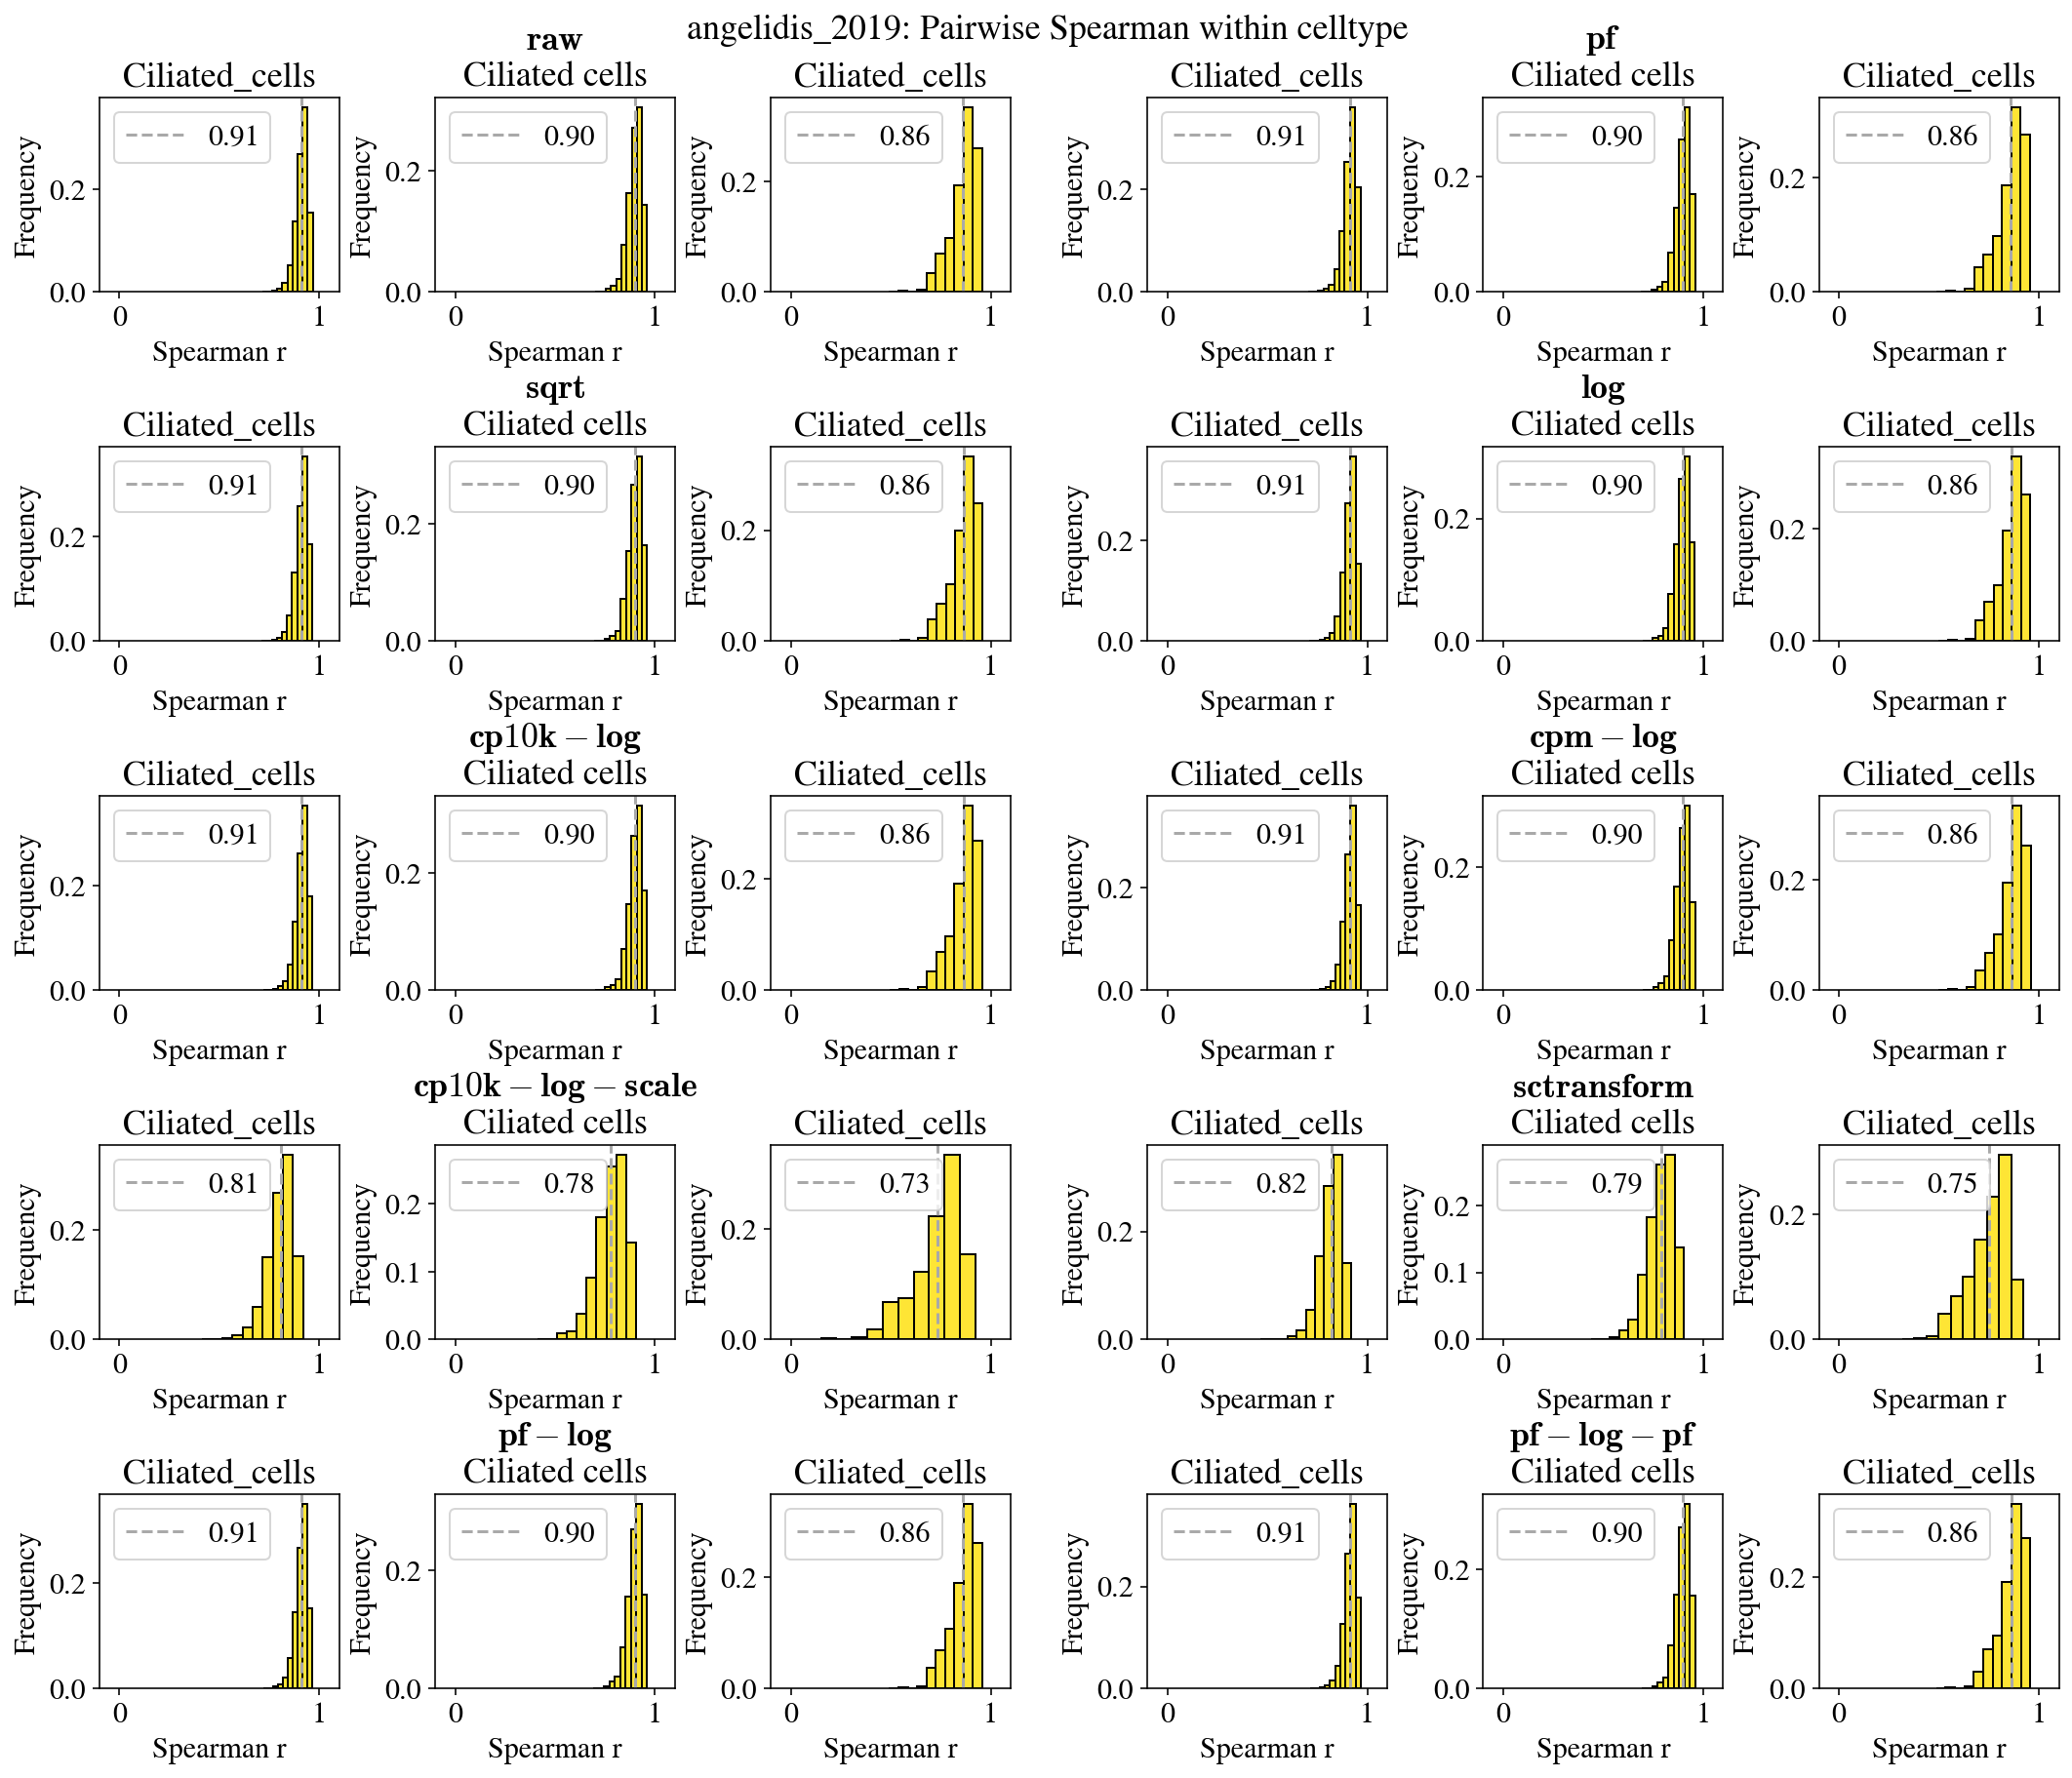

In [1251]:
fig = plt.figure(figsize=(6*3,5*3))
fig.suptitle(f"{ds}: Pairwise Spearman within celltype", y=0.92)
gs = gridspec.GridSpec(5, 2, figure=fig, wspace=0.15, hspace=0.8)
axs = []
for i in range(5):
    for j in range(2):
        ig = gs[i,j].subgridspec(1, 3, wspace=0.4)
        ax1 = fig.add_subplot(ig[0, 0])
        ax2 = fig.add_subplot(ig[0, 1])
        ax3 = fig.add_subplot(ig[0, 2])
        axs.append((ax1, ax2, ax3))

minlim = -0.1
maxlim = 1.1

p = {
    "xlabel": "Spearman r",
    "ylabel": "Frequency",
    "xlim": (minlim, maxlim)
}

for ax, title in zip(axs, labels):
    for idx, (a, c) in enumerate(zip(ax, celltypes)):
        x = ct_sp[title][c]
        
        c = ' '.join(ct.split('_'))
    
        weights = np.ones(len(x)) / len(x)
        a.hist(x, weights=weights, facecolor=colors["mono"], edgecolor="k")
        a.axvline(x.mean(), color="darkgray", linestyle="--", label=f"{x.mean():,.2f}")
        p.update({"title": ct})
        if idx == 1:
            p.update({"title": fr"$\bf{'-'.join(title.split('_'))}$" + f"\n{c}"})

        a.set(**p)
        a.legend()
fig.savefig(f"{ds}_celltype_pairwise_spearman.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

In [934]:
ct_metrics = defaultdict(dict)

In [935]:
# celltype specific metrics
# This will be on Alveolar macrophages

for k, v in ct_sp.items():
    for m, s in v.items():
        ct_metrics[k]["ct_spearman"] = s.mean()


In [936]:
ct_metrics

defaultdict(dict,
            {'raw': {'ct_spearman': 0.8627245368699216},
             'pf': {'ct_spearman': 0.860210899660359},
             'sqrt': {'ct_spearman': 0.8639060906095202},
             'log': {'ct_spearman': 0.8630495648695986},
             'cp10k_log': {'ct_spearman': 0.8638127389044951},
             'cpm_log': {'ct_spearman': 0.8649978480723757},
             'cp10k_log_scale': {'ct_spearman': 0.7347061154502037},
             'sctransform': {'ct_spearman': 0.7526148260556507},
             'pf_log': {'ct_spearman': 0.862093678616872},
             'pf_log_pf': {'ct_spearman': 0.8625469949655062}})

## knee and mean var

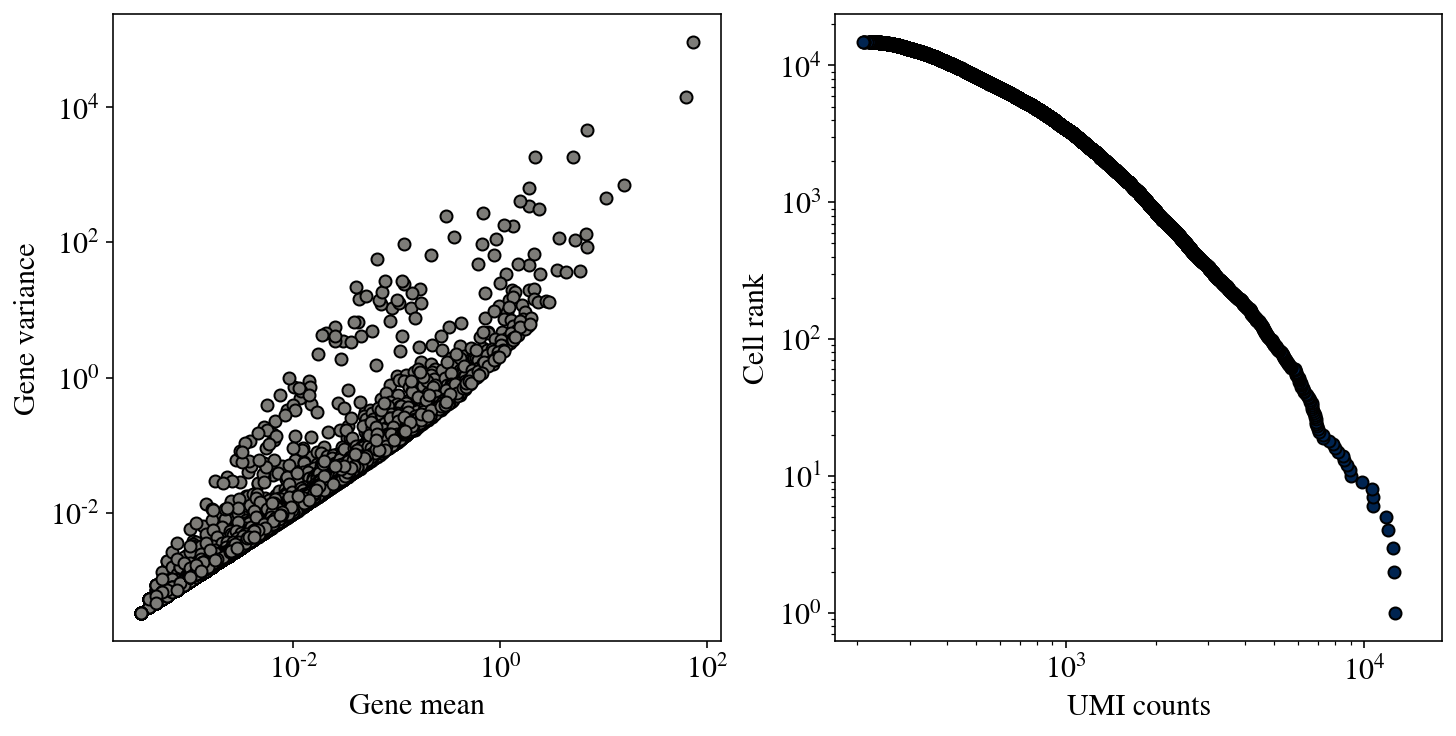

In [1238]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, constrained_layout=True)

ax = axs[0]

x = data["raw"].mean(0)
y = np.var(data["raw"], axis=0)

ax.scatter(x,y, facecolor=colors["gene"], edgecolor="k")

ax.set(**{
    "xlabel": "Gene mean",
    "ylabel": "Gene variance",
    "xscale": "log",
    "yscale": "log"
})

ax = axs[1]

x = np.sort(data["raw"].sum(1))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x,y, facecolor=colors["cell"], edgecolor="k")

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMI counts",
    "ylabel": "Cell rank"
})

fig.savefig(f"{ds}_knee_meanvar.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

## cp10k_log_scale v sctransform

In [55]:
def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [56]:
pr = defaultdict()
for c, c_mask in zip(celltypes, ct_masks):
    pr[c] = np.diagonal(corr2_coeff(data["cp10k_log_scale"][c_mask], data["sctransform"][c_mask]))

In [92]:
spr = defaultdict()
for c, c_mask in zip(celltypes, ct_masks):
    spr[c] = np.diagonal(corr2_coeff(stats.rankdata(data["cp10k_log_scale"][c_mask], axis=1), stats.rankdata(data["sctransform"][c_mask], axis=1)))

In [ ]:
# make y axis same scale, fix spacing

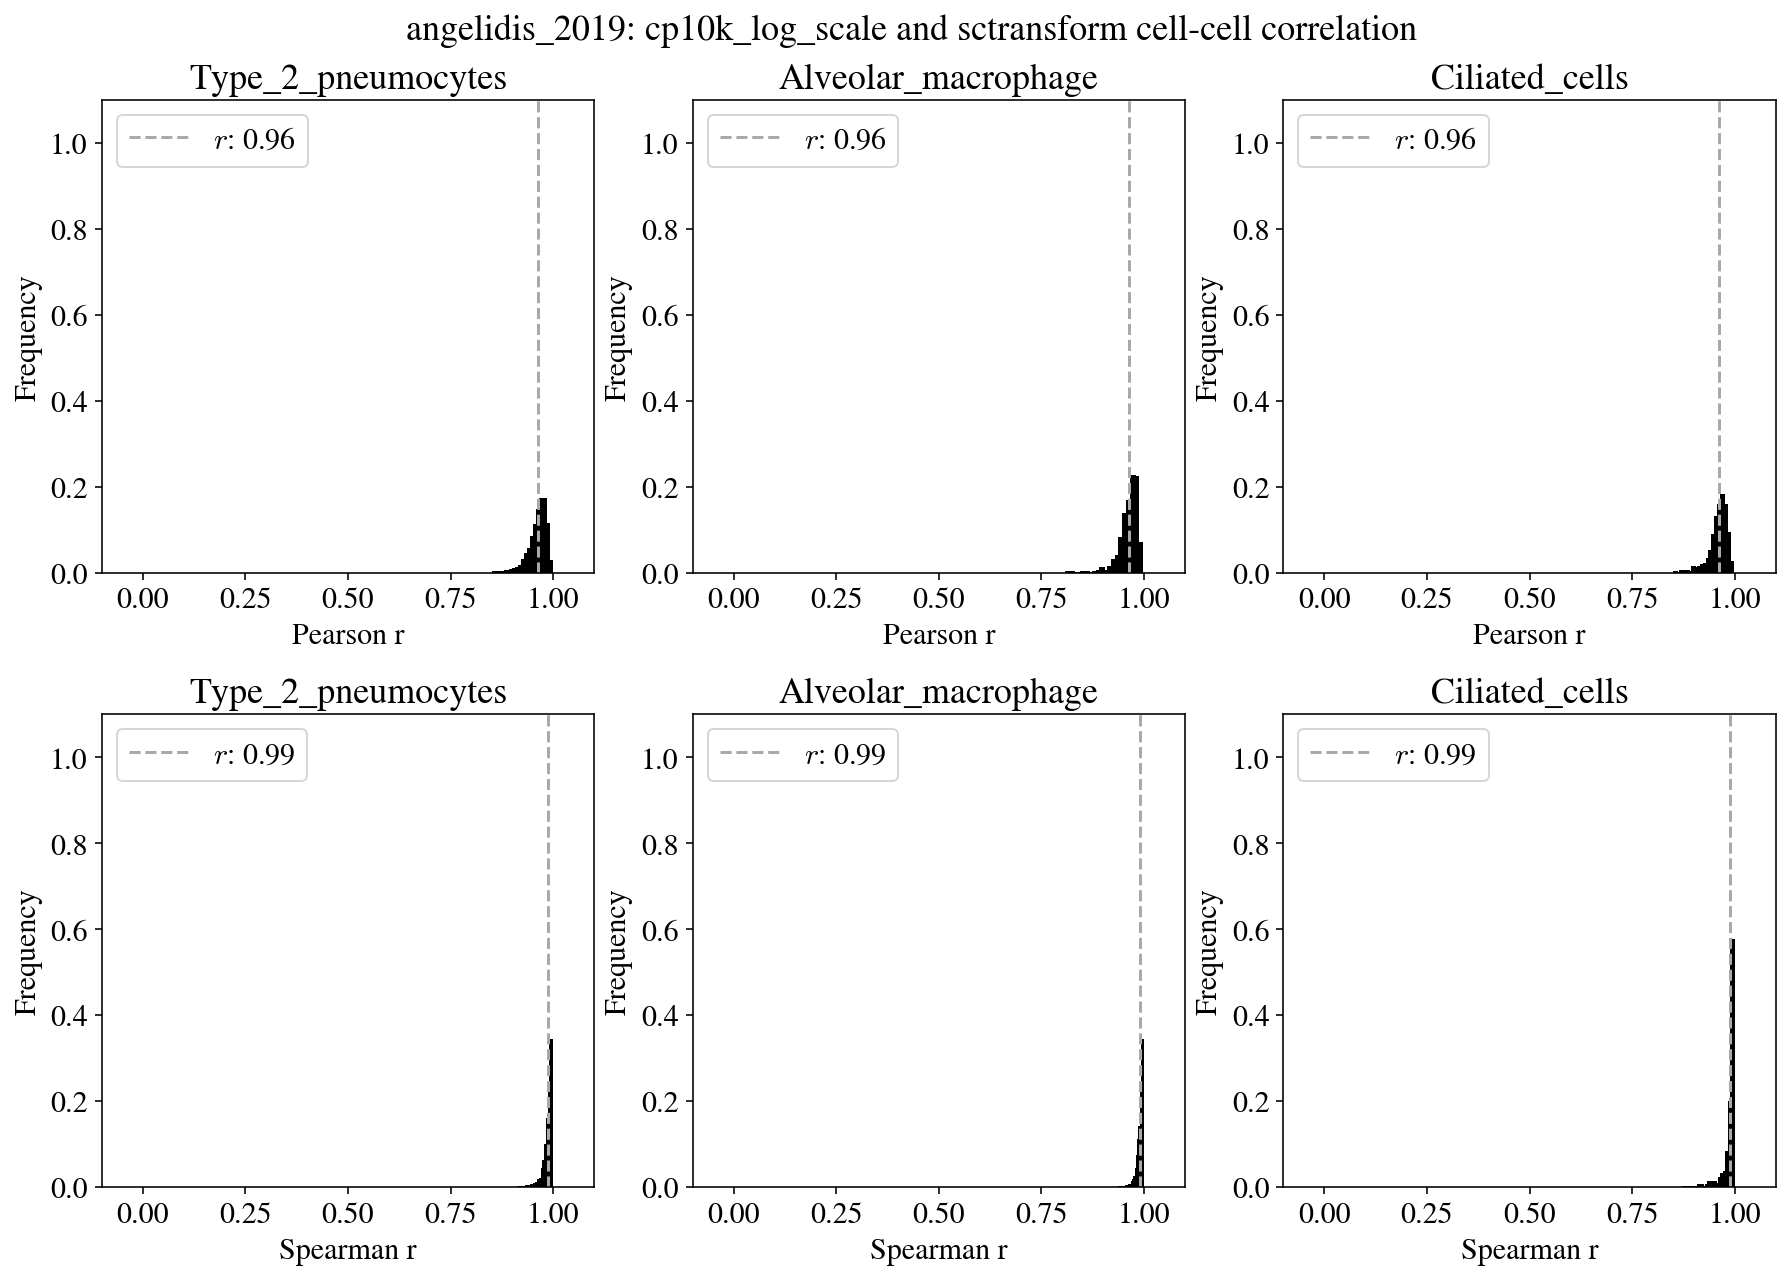

In [1253]:
nr, nc = 2, 3
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(f"{ds}: cp10k_log_scale and sctransform cell-cell correlation", y=0.94)
fig.subplots_adjust(hspace=0.3)
p = {
        "xlim": (-0.1, 1.1)
}


for idx, ct in enumerate(celltypes):
    ax = axs[0,idx]

    x = pr[ct]

    weights=np.ones(len(x)) / len(x)
    ax.hist(x, weights=weights, facecolor="k", edgecolor="k", bins=20)
    ax.axvline(x.mean(), label=f"$r$: {x.mean():,.2f}", linestyle="--", color="darkgray")
    ax.set(**{
        "xlim": (-0.1, 1.1),
        "ylim": (0, 1.1),
        "title": ct,
        "xlabel": "Pearson r",
        "ylabel": "Frequency"
    })
    ax.legend()

for idx, c in enumerate(celltypes):
    ax = axs[1,idx]
    p.update({"title": f"{c}"})

    x = spr[c]

    weights=np.ones(len(x)) / len(x)
    ax.hist(x, weights=weights, facecolor="k", edgecolor="k", bins=20)
    ax.axvline(x.mean(), label=f"$r$: {x.mean():,.2f}", linestyle="--", color="darkgray")
    ax.set(**{
        "xlim": (-0.1, 1.1),
        "ylim": (0, 1.1),
        "title": c,
        "xlabel": "Spearman r",
        "ylabel": "Frequency"
    })
    
    ax.legend()
fig.savefig(f"{ds}_cp10k_log_scale_sctransform_spearman.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

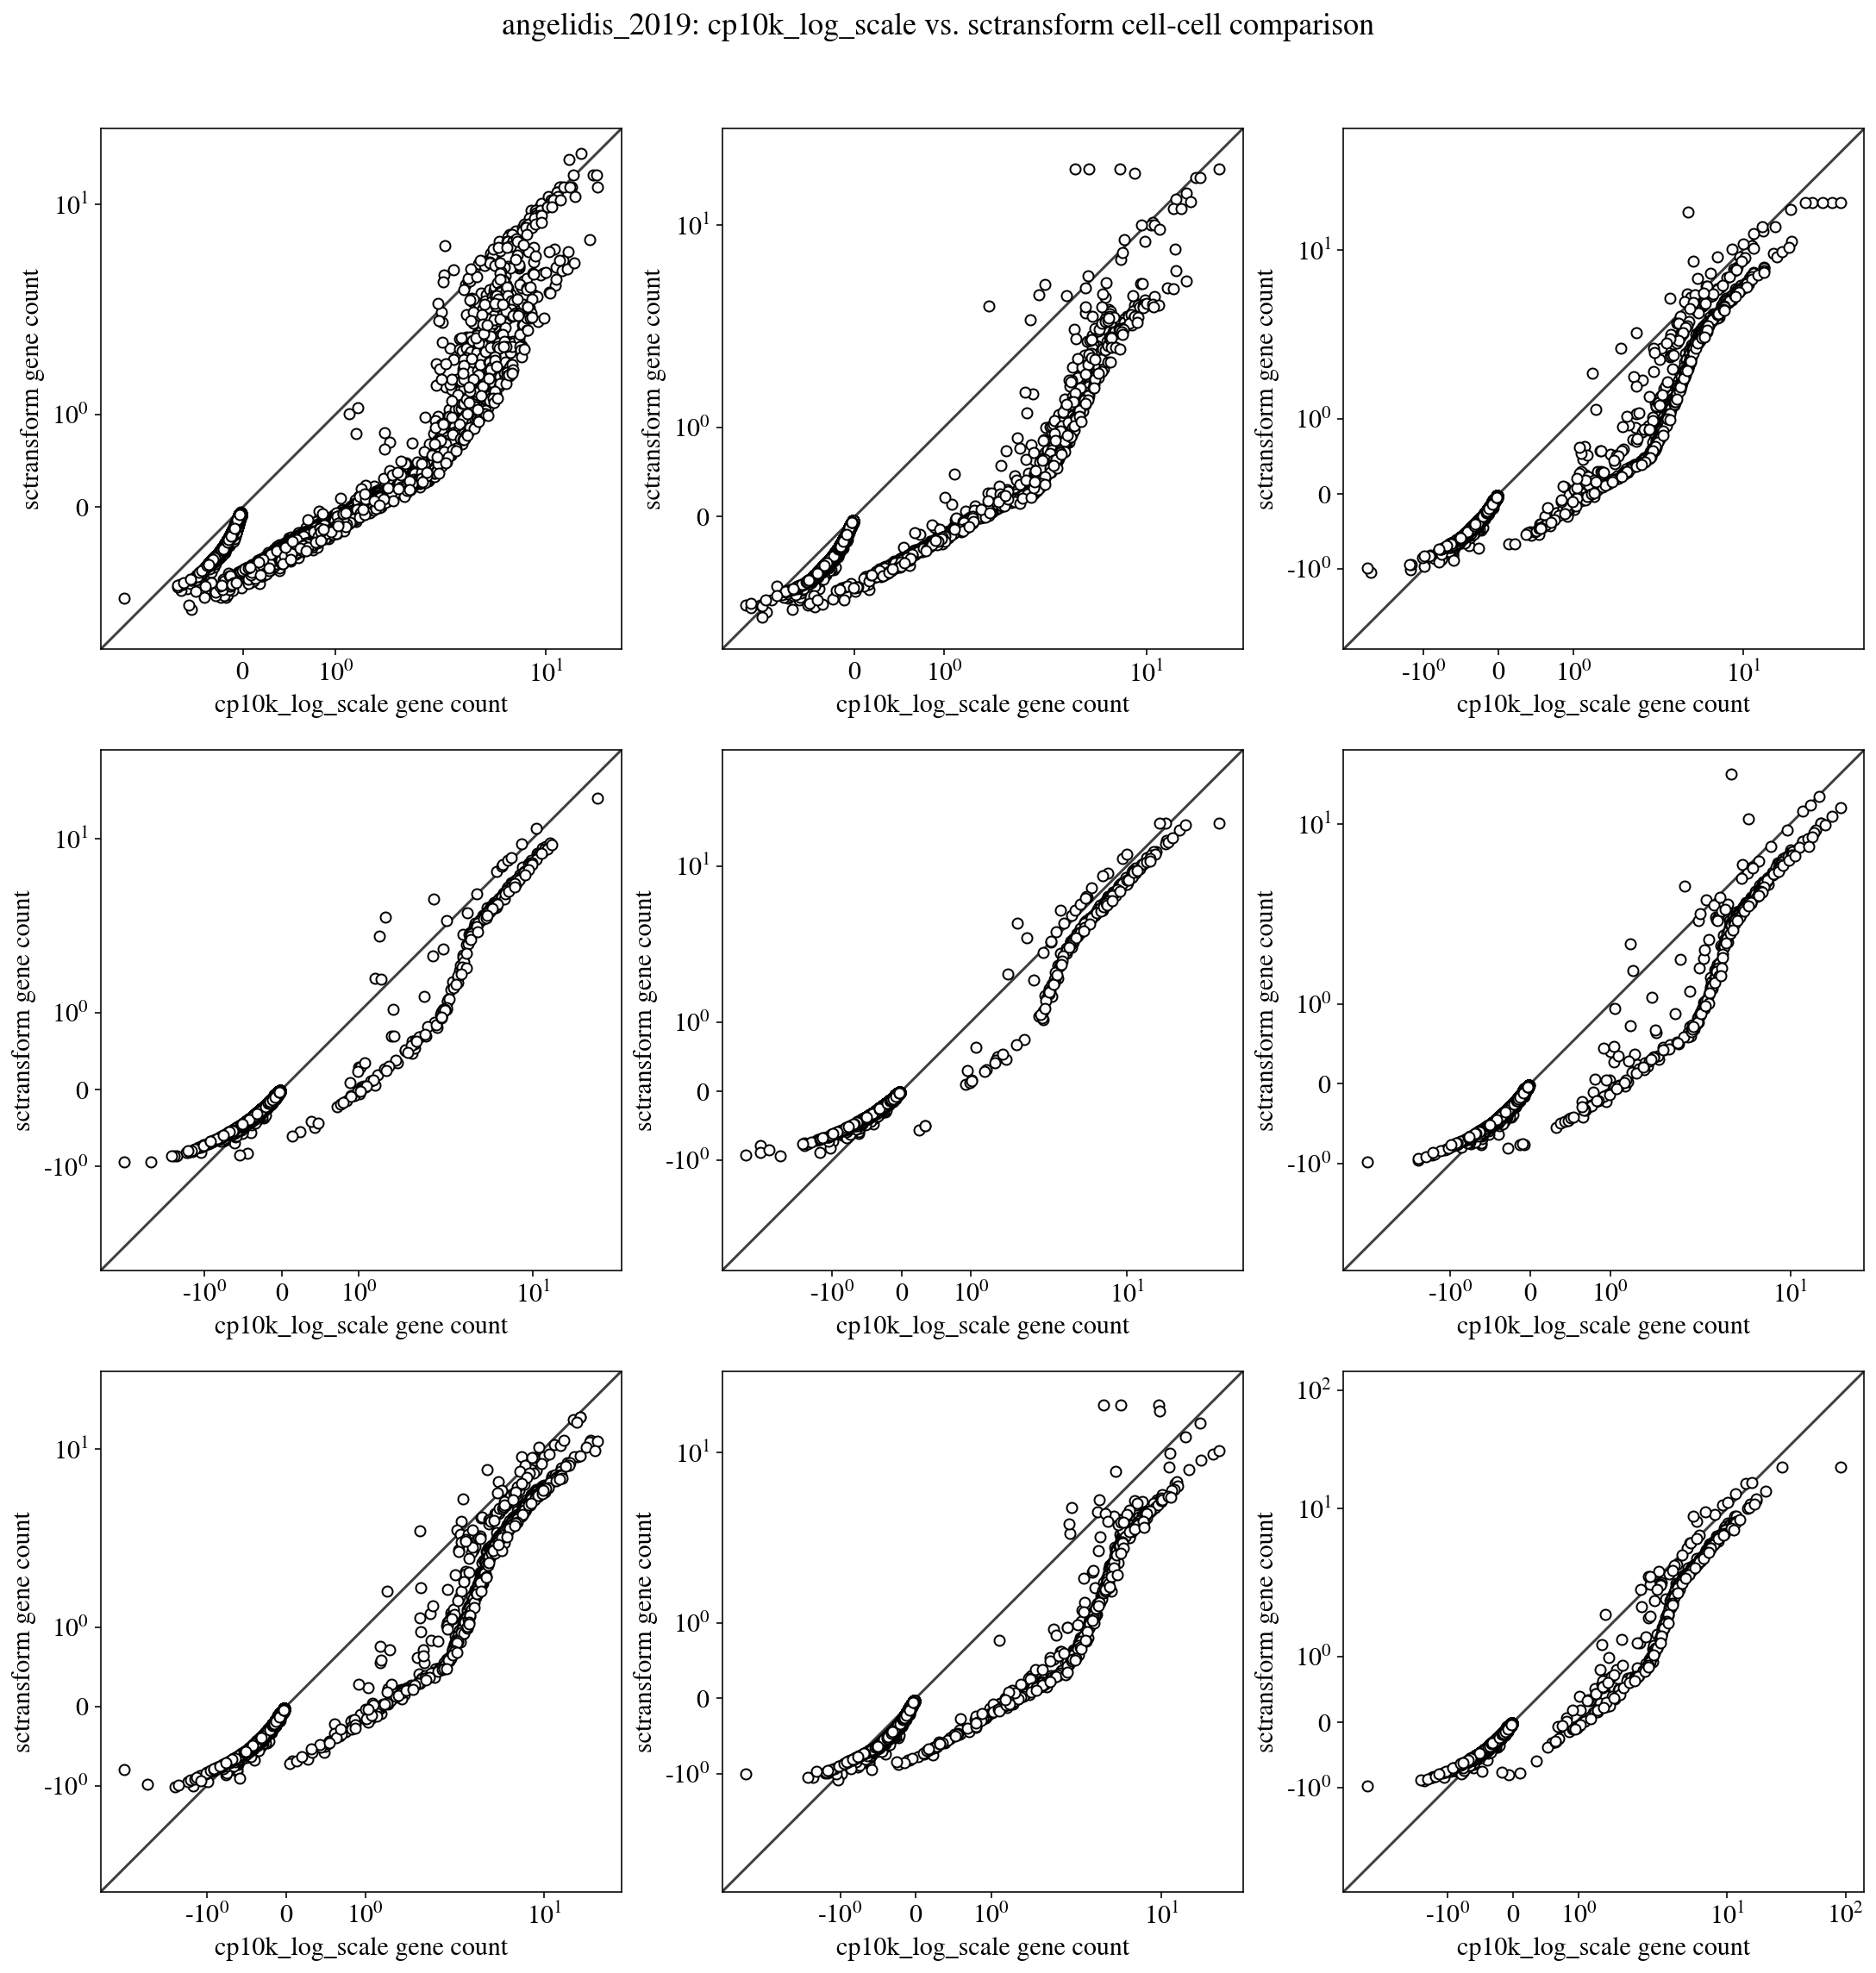

In [1268]:
n = 3
fig, axs = plt.subplots(figsize=(5*n,5*n), ncols=n, nrows=n, constrained_layout=True)
fig.suptitle(f"{ds}: cp10k_log_scale vs. sctransform cell-cell comparison", y=1.05)

for idx, ax in enumerate(fig.axes):
    x = data["cp10k_log_scale"][-idx]
    y = data["sctransform"][-idx]
    ax.scatter(x,y, facecolor="white", edgecolor="k")
    
    ax.set(**{
        "xlabel": "cp10k_log_scale gene count",
        "ylabel": "sctransform gene count",
        "xscale": "symlog",
        "yscale": "symlog",
    })
    yex(ax)

fig.savefig(f"{ds}_cp10k_log_scale_sctransform_spearman_cell_examples.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# PC variance

In [226]:
data["raw"].shape

(14813, 16541)

In [ ]:
%%time
# ## data for pc
pcs = {}
for title, matrix in data.items():
    print(title)
    pca = PCA(n_components=1, svd_solver='full')
    Y = pca.fit_transform(matrix)[ctype_mask]
    pcs[title] = pca.components_

raw
pf
log
pf_log
pf_log_pf
cpm_log
cp10k_log


In [938]:
cmp = np.zeros((len(labels)))
mean = data["raw"].mean(0) # gene means
p = np.zeros((len(labels), len(genes)))
for idx, l in enumerate(labels):
    pc = np.abs(pcs[l]) # gene loadings
    pcn = normalize(pc, norm="l1")[0]
    ent = stats.entropy(pcn)
    print(f"{l}\t{ent}")
    p[idx] = pcn
    cmp[idx] = ent
    ct_metrics[l]["pc_entropy"] = ent

raw	3.9040854151515143
pf	4.348073993861654
sqrt	8.39783800794595
log	8.680539452718548
cp10k_log	8.380080951964228
cpm_log	8.910519956491422
cp10k_log_scale	9.080792346366124
sctransform	9.205370891317408
pf_log	8.06678830540813
pf_log_pf	7.940016374943765


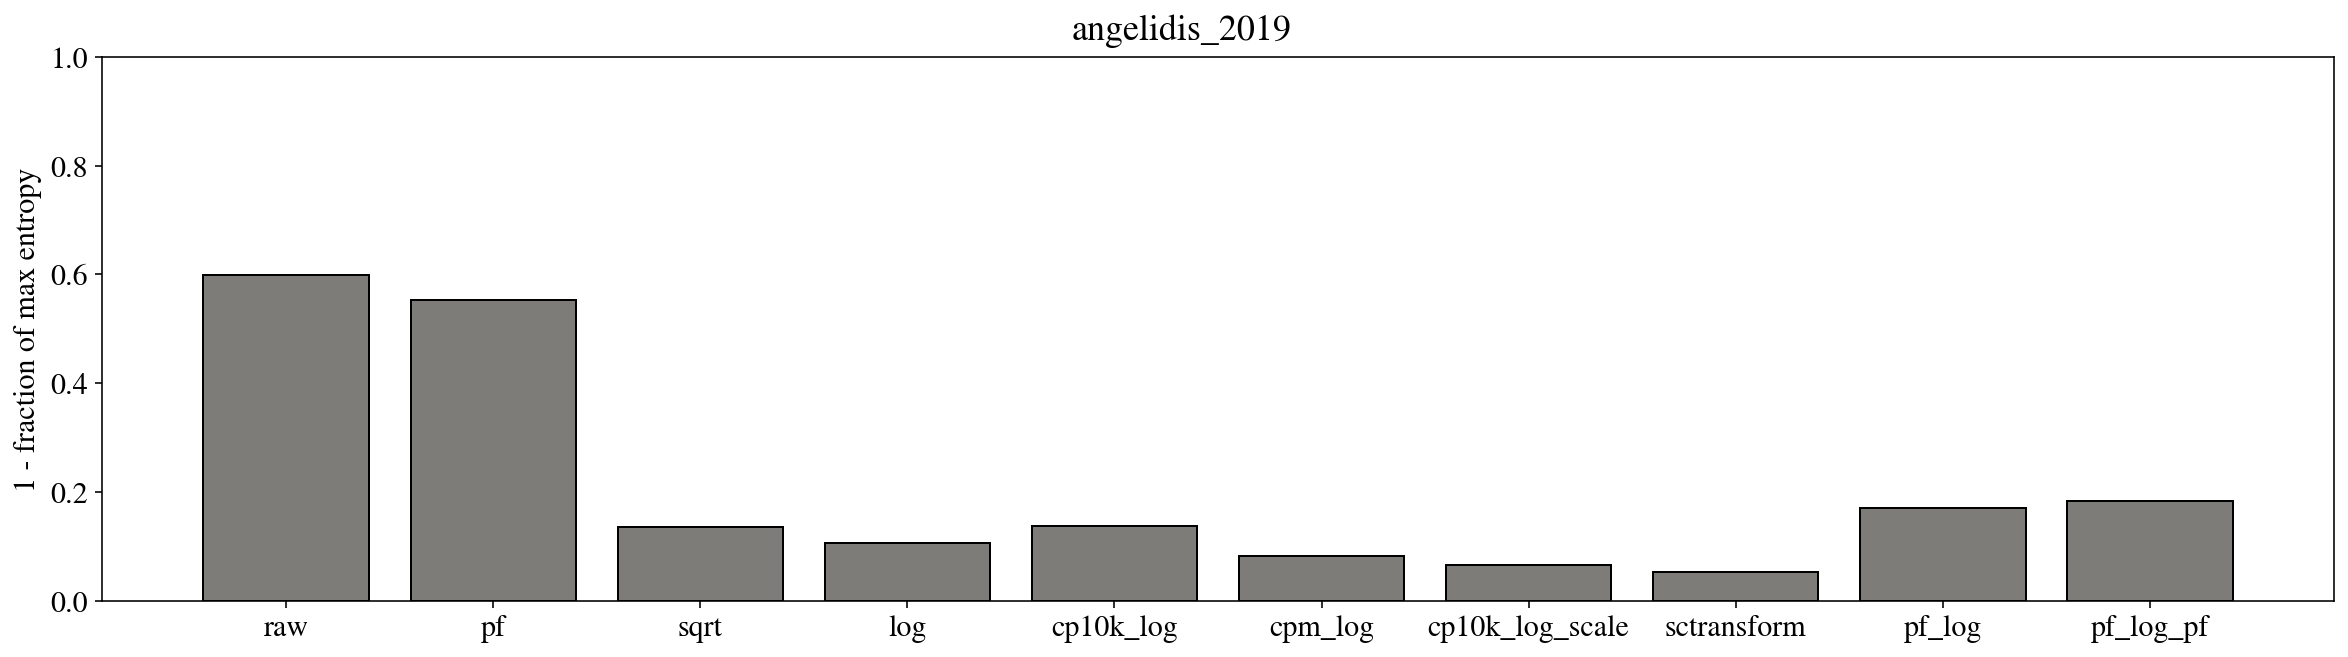

In [987]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle(ds, y=0.94)
x = labels
y = cmp
max_ent = np.log(len(genes))
ax.bar(x,(max_ent - y)/max_ent, facecolor=colors["gene"], edgecolor="k")
ax.set(**{
    "ylabel": "1 - fraction of max entropy",
    "ylim": (0, 1)
})
fig.savefig(f"{ds}_pc_entropy.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()

In [704]:
# todo make this plot for svensson data

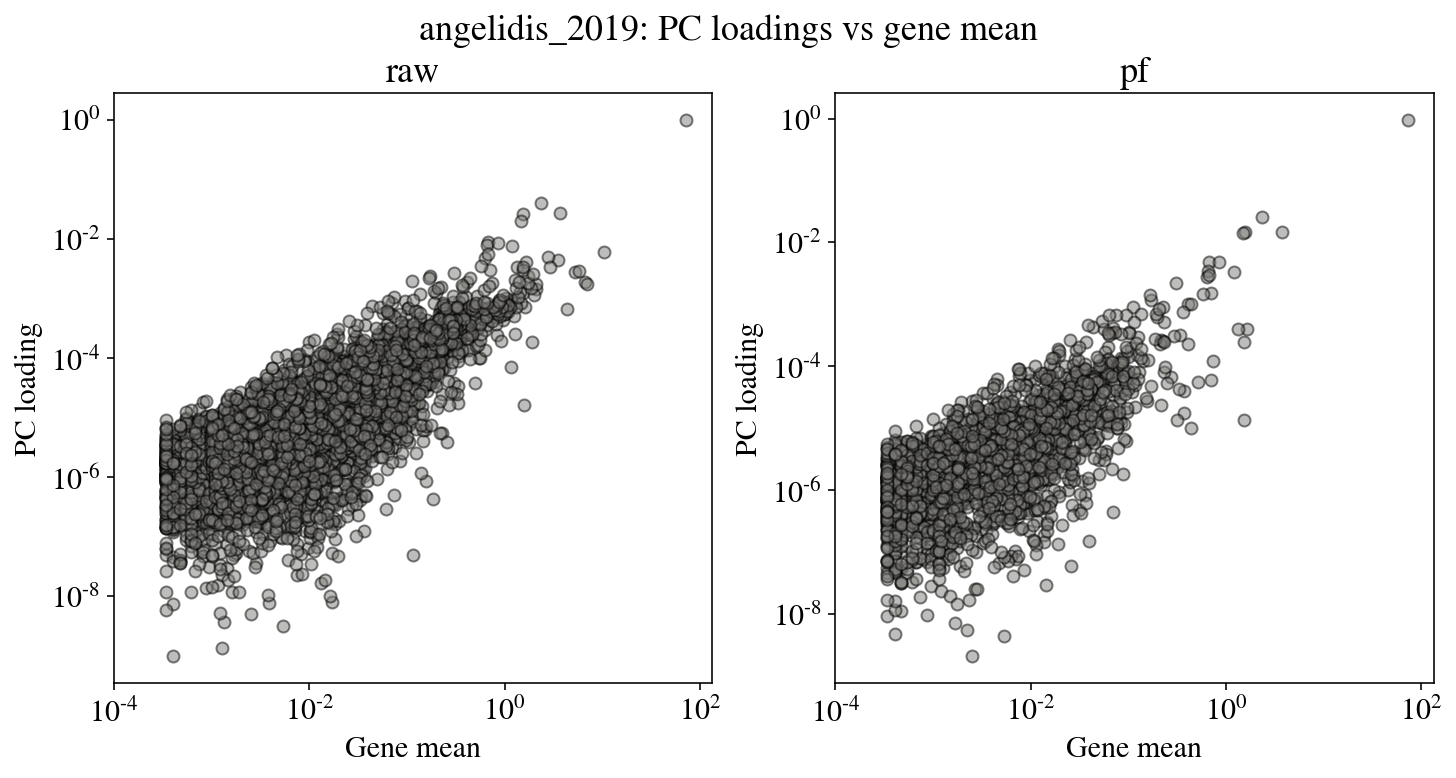

In [1255]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)
fig.suptitle(f"{ds}: PC loadings vs gene mean", y=1.05)
ax = axs[0]
# todo add pf to this one
x = np.mean(data["raw"], 0)
y = pcs["raw"][0]

ax.scatter(x,y, alpha=0.5, facecolor=colors["gene"], edgecolor="k")
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlim": (1e-4),
    "xlabel": "Gene mean",
    "ylabel": "PC loading",
    "title": "raw"
})

ax = axs[1]
# todo add pf to this one
x = np.mean(data["raw"], 0)
y = pcs["pf"][0]

ax.scatter(x,y, alpha=0.5, facecolor=colors["gene"], edgecolor="k")
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlim": (1e-4),
    "xlabel": "Gene mean",
    "ylabel": "PC loading",
    "title": "pf"
})

fig.savefig(f"{ds}_pc_raw_loadings.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# Heatmaps

In [1053]:
dropna = pd.notna(assignments)

In [1054]:
mg = diff(data["pf"][dropna], bcs.index.values[dropna], genes, assignments[dropna])

07-Mar-22 17:29:03 - 1 of 33 assignments: Alveolar_macrophage
07-Mar-22 17:29:11 - 2 of 33 assignments: B_cells
07-Mar-22 17:29:13 - 3 of 33 assignments: CD209+/Cd11b+_dendritic_cells
07-Mar-22 17:29:15 - 4 of 33 assignments: CD8+_T_cells
07-Mar-22 17:29:16 - 5 of 33 assignments: Capillary_endothelial_cells
07-Mar-22 17:29:17 - 6 of 33 assignments: Ccl17+/Cd103-/Cd11b-_dendritic_cells
07-Mar-22 17:29:19 - 7 of 33 assignments: Cd103+/Cd11b-_dendritic_cells
07-Mar-22 17:29:20 - 8 of 33 assignments: Cd4+_T_cells
07-Mar-22 17:29:21 - 9 of 33 assignments: Ciliated_cells
07-Mar-22 17:29:23 - 10 of 33 assignments: Club_cells
07-Mar-22 17:29:25 - 11 of 33 assignments: Eosinophils
07-Mar-22 17:29:26 - 12 of 33 assignments: Fn1+_macrophage
07-Mar-22 17:29:27 - 13 of 33 assignments: Gamma-Delta_T_cells
07-Mar-22 17:29:31 - 14 of 33 assignments: Goblet_cells
07-Mar-22 17:29:32 - 15 of 33 assignments: Interstitial_Fibroblast
07-Mar-22 17:29:34 - 16 of 33 assignments: Interstitial_macrophages
07-Mar

In [1055]:
markers = mg.query("es > 1 & p_corr < 0.01").sort_values('es', ascending = False)

markers = markers[~markers["name"].duplicated()].groupby('group_id').head(3)

mgenes = markers.sort_values("group_id")["name"]

In [1056]:
gb = {}

# average expression for each celltype

for title in labels:
    df = pd.DataFrame(data[title], index=assignments)
    gg = df.groupby(df.index.get_level_values(0)).mean()
    asn = gg.index.values
    gb[title] = gg.values

In [1041]:
ac = {}

# all values

for title in labels:
    df = pd.DataFrame(data[title], index=assignments)
    gg = pd.DataFrame(data[title], index=assignments).sort_index()
    asn = gg.index.values
    ac[title] = gg.values

In [1019]:
pltlabels = ['pf',
 'pf_log_pf',
'cp10k_log_scale',
 'sctransform',
]

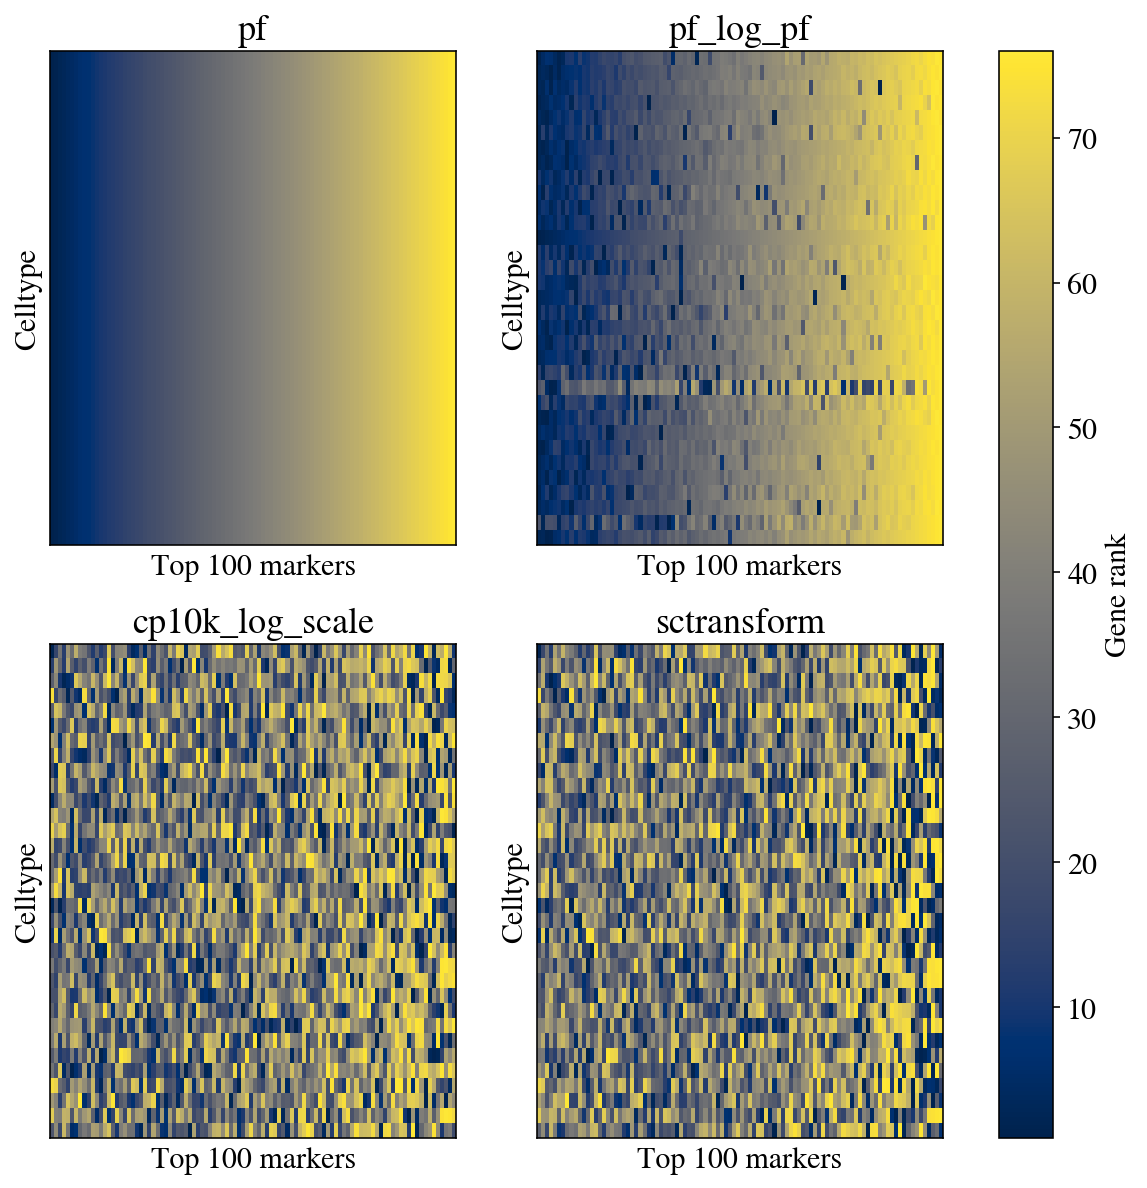

In [1022]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)

nm = 100
ridx = np.argsort(gb["pf"], axis=1)[:,-nm:]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method]

    # take top 100 genes (by ranking in raw expression)
    mat = np.take_along_axis(mat, ridx, 1)
    
    # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")
    
    ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(**{
        "ylabel": "Celltype",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")
#fig.savefig(f"{ds}_celltype_scramble.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

In [581]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","black","firebrick"], N=256)

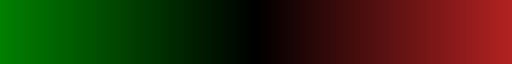

In [582]:
cmap

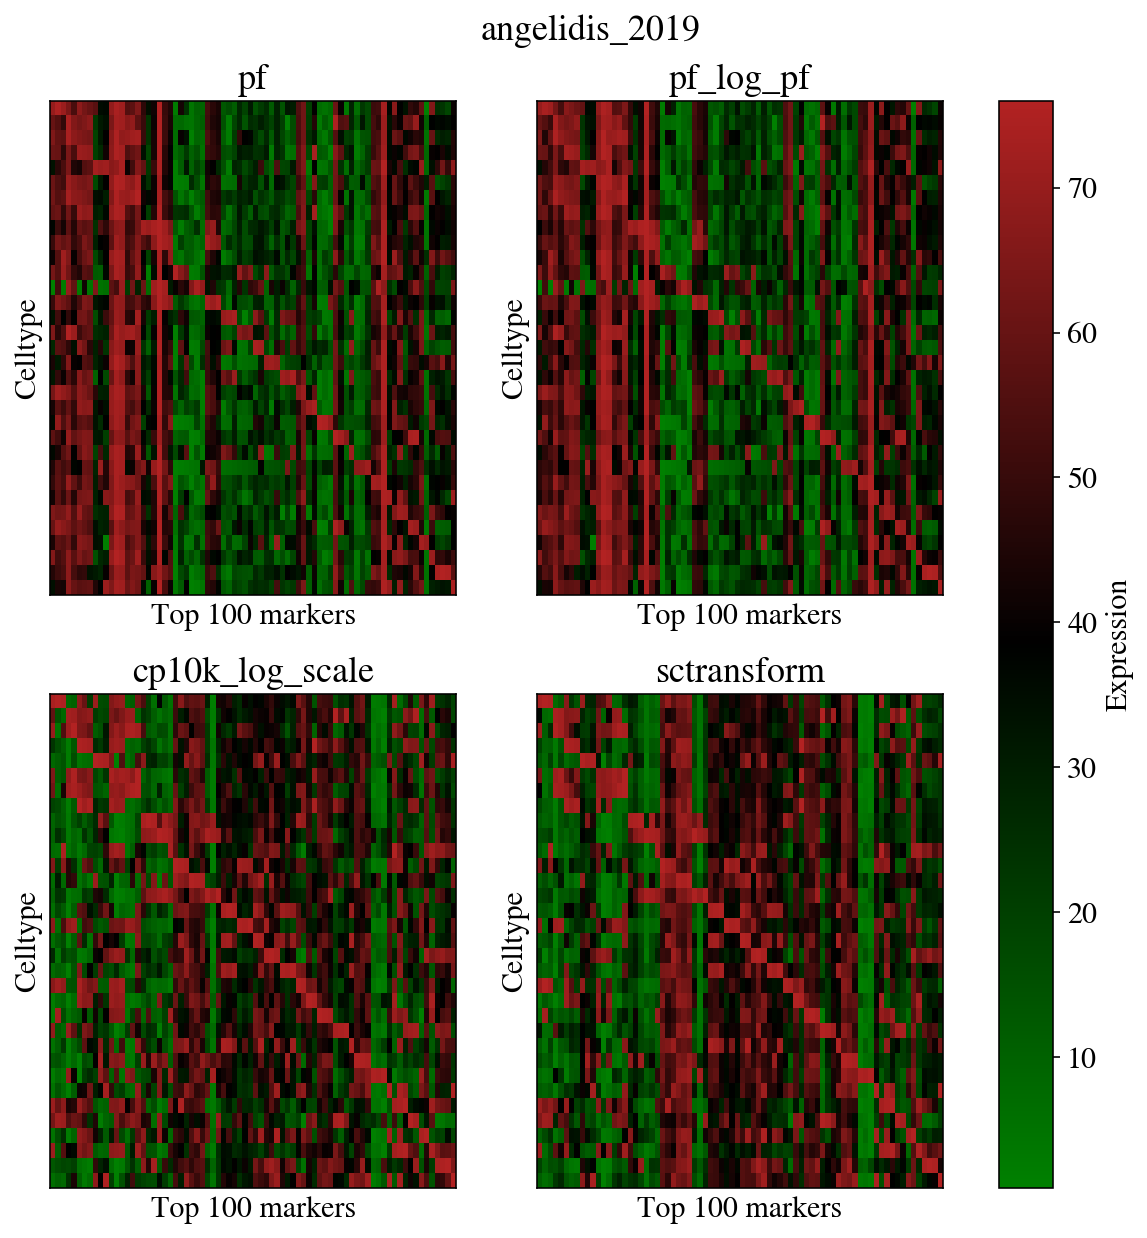

In [640]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method][:, mgenes_idx]

#     # take top 100 genes (by ranking in raw expression)
#     mat = np.take_along_axis(mat, ridx, 1)
    
#     # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")
    
    im = ax.imshow(mat, aspect="auto", cmap=cmap)
    ax.set(**{
        "ylabel": "Celltype",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Expression")

fig.savefig(f"{ds}_celltype_markergene_rank_collins.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

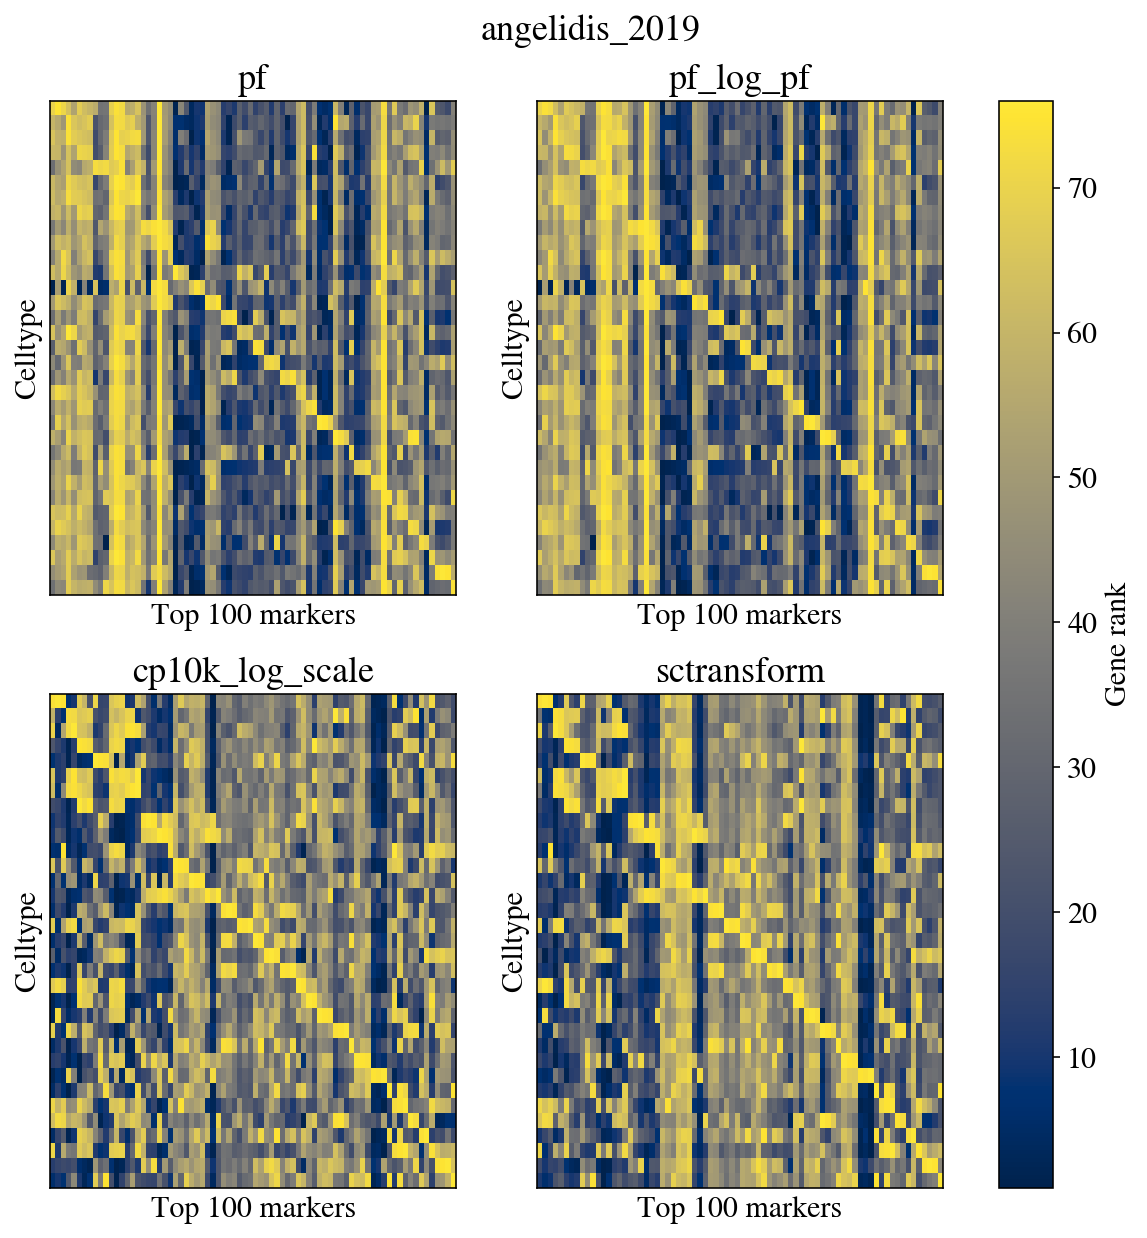

In [641]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method][:, mgenes_idx]

#     # take top 100 genes (by ranking in raw expression)
#     mat = np.take_along_axis(mat, ridx, 1)
    
#     # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")
    
    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(**{
        "ylabel": "Celltype",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")

fig.savefig(f"{ds}_celltype_markergene_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

In [1028]:
pltlabels = ['raw',
 'pf_log_pf',
'cp10k_log_scale',
 'sctransform',
]

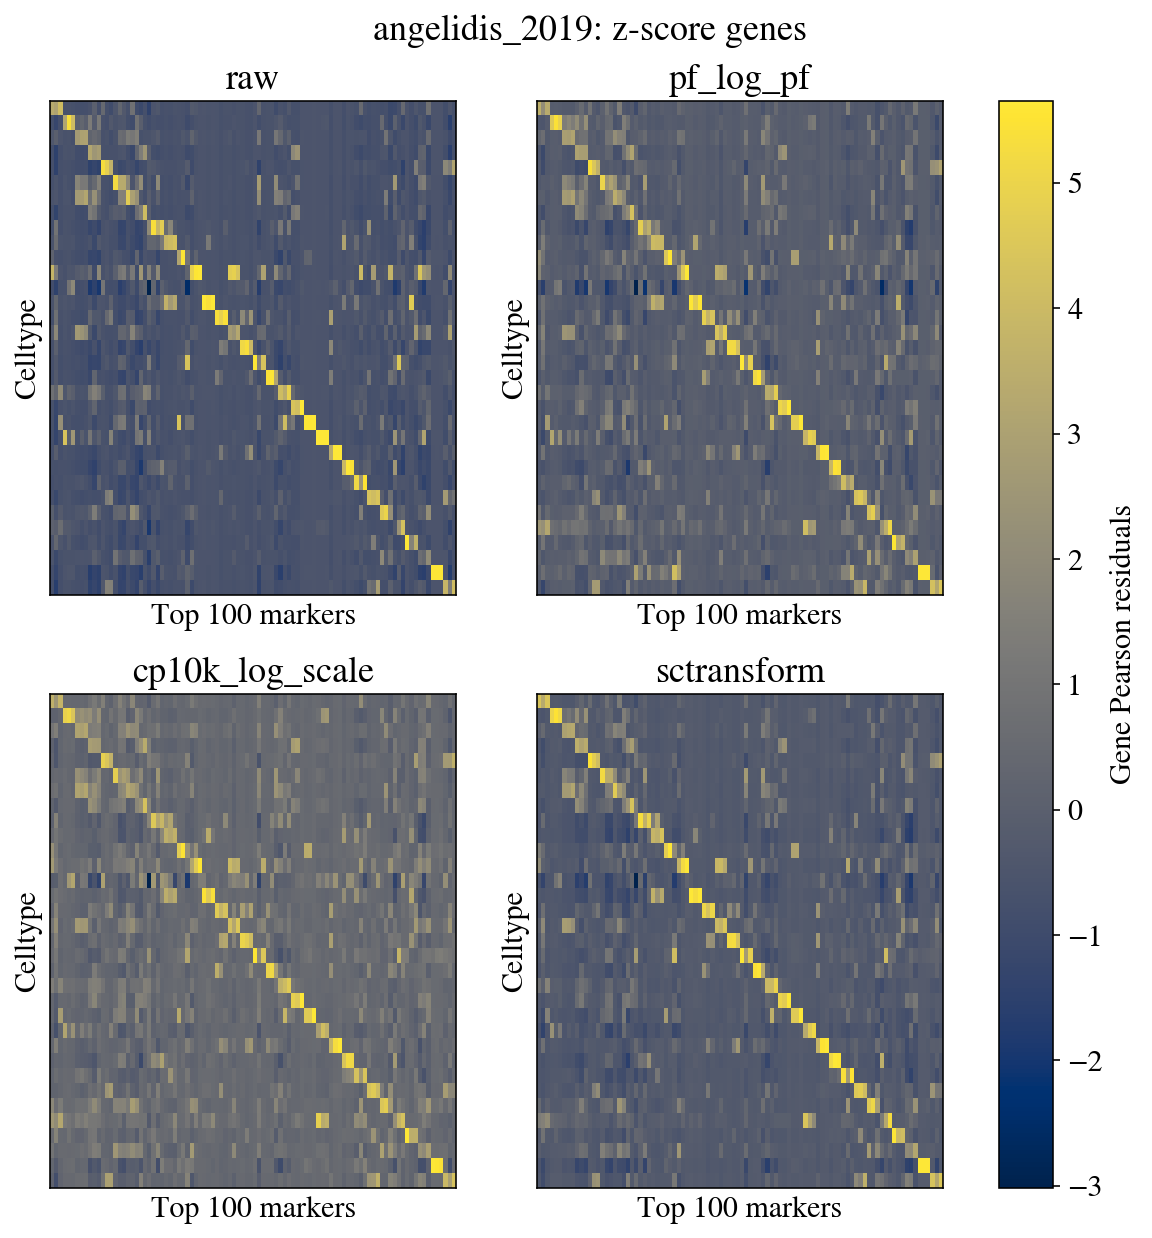

In [1057]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(f"{ds}: z-score genes", y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method]
    
    # scale genes to zero mean unit variance
    mat = scale(mat)
    
    mat = mat[:, mgenes_idx]
    
    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(**{
        "ylabel": "Celltype",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene Pearson residuals")

#fig.savefig(f"{ds}_celltype_markergene_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

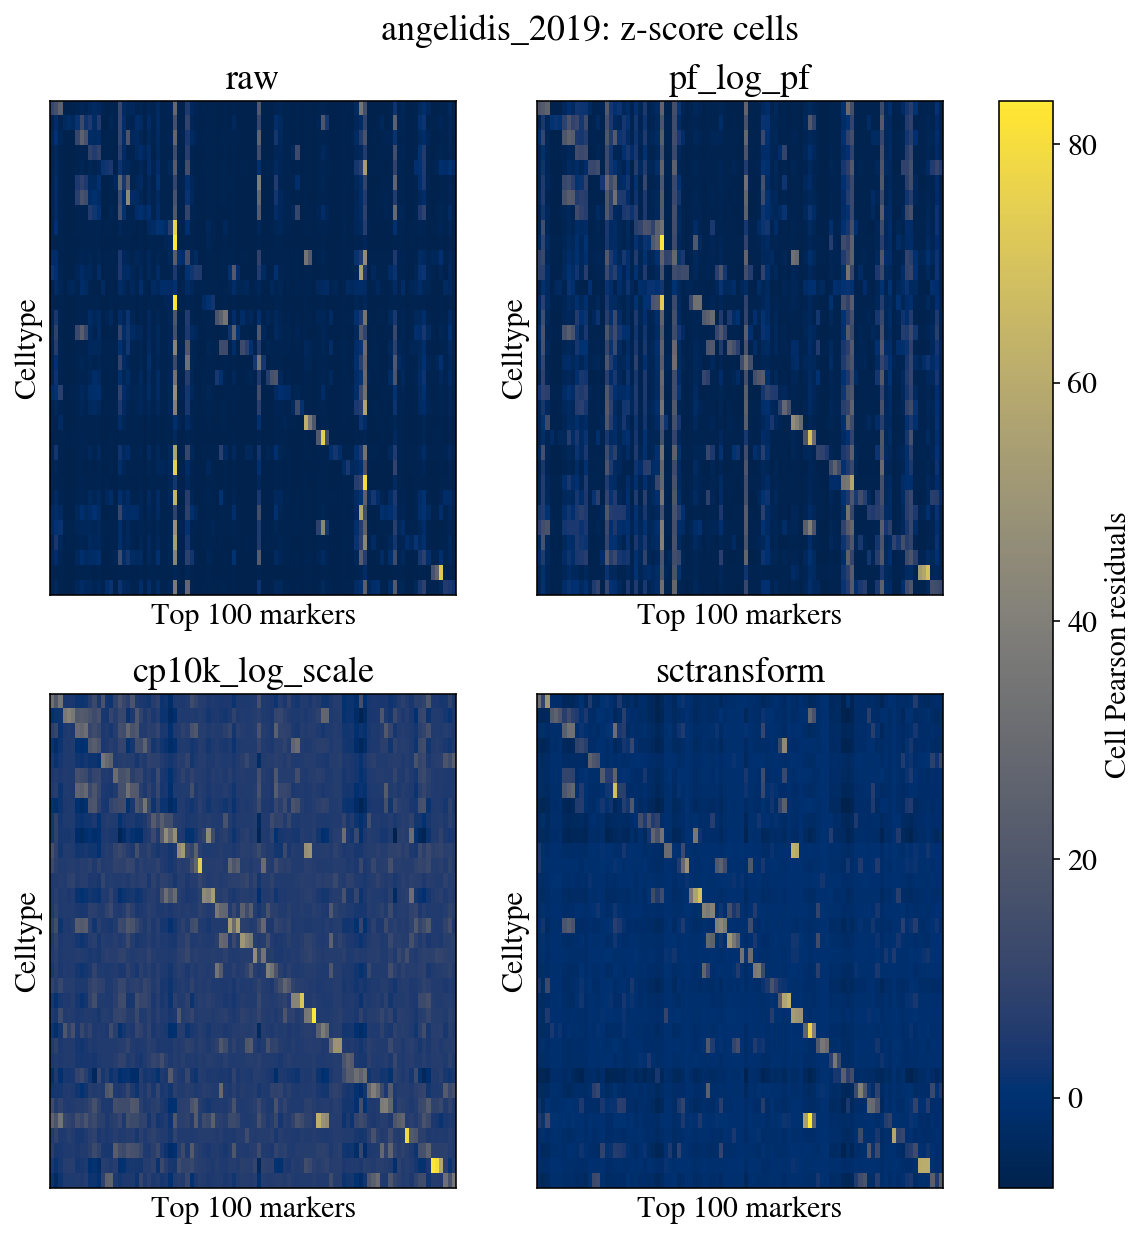

In [1058]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(f"{ds}: z-score cells", y=0.94)
mgenes_idx = [list(genes).index(i) for i in mgenes]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = gb[method]
    
    # scale genes to zero mean unit variance
    mat = scale(mat, axis=1)
    
    mat = mat[:, mgenes_idx]
    
    im = ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(**{
        "ylabel": "Celltype",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Cell Pearson residuals")

#fig.savefig(f"{ds}_celltype_markergene_rank.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

In [ ]:
# when looking at celltypes, you will rank the top genes by "Expression"
# you wont see the top genes being the same with cls or sctransform because the ranking of cells is scrambled
# the top genes could be shared between many celltypes and you dont know whether a gene is highly expressed over all or specific to that celltype

In [436]:
ctd = {}
ct = celltypes[0]
ct_mask = ctype_masks[0]

for title in labels:
    df = pd.DataFrame(data[title], index=assignments)
    df = df[ct_mask]
    ctd[title] = df.values

In [448]:
mats= {}
rankmats={}

In [644]:
pltlabels = ['raw',
 'pf_log_pf',
'cp10k_log_scale',
 'sctransform',
]

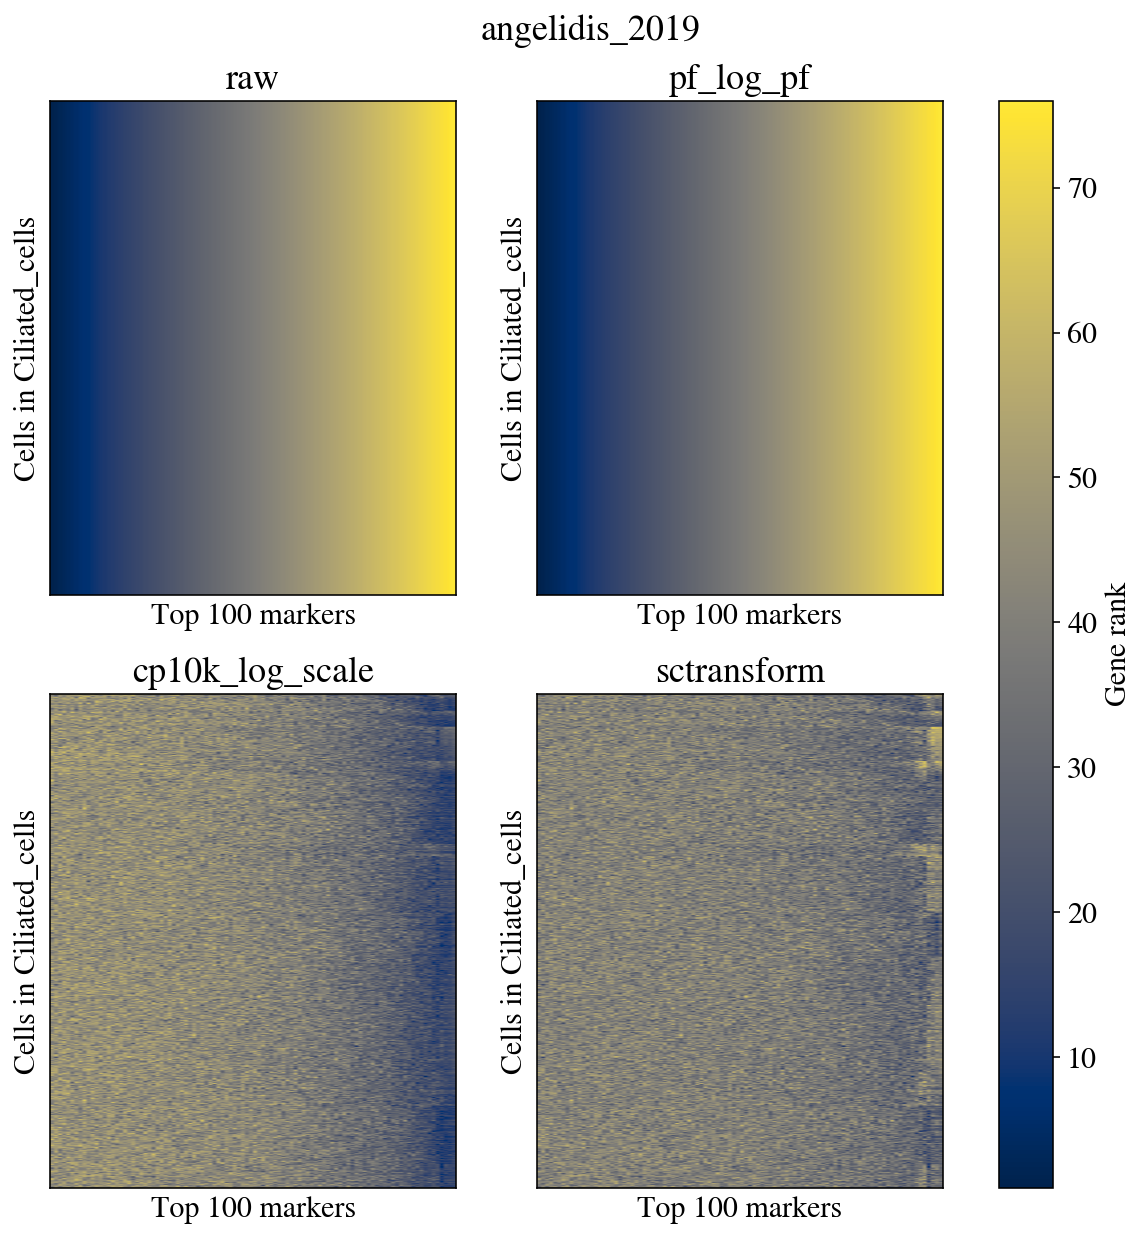

In [645]:
nr = 2
nc = 2
fig, axs = plt.subplots(figsize=(5*nc,5*nr), ncols=nc, nrows=nr)
fig.suptitle(ds, y=0.94)

nm = 100
ridx = np.argsort(ctd["raw"], axis=1)[:,-nm:]

for l, ax in zip(pltlabels, fig.axes):
    method = l

    # every cell type across all genes
    mat = ctd[method]

    # take top 100 genes (by ranking in raw expression)
    mat = np.take_along_axis(mat, ridx, 1)
    mats[l] = mat
    # plot the order of their expression
    mat = stats.rankdata(mat, axis=1, method="ordinal")
    rankmats[l] = mat
    
    ax.imshow(mat, aspect="auto", cmap="cividis")
    ax.set(**{
        "ylabel": f"Cells in {ct}",
        "xlabel": f"Top {nm} markers",
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
        "title": method
    })
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=1, label="Gene rank")
fig.savefig(f"{ds}_cell_scramble.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# DE on highest variable cluster

In [990]:
cellsum = data["raw"][ct_mask].sum(1)

In [991]:
n = 1000
min_sidx, max_sidx = np.array_split(np.argsort(cellsum), 2)

# ## for truncating
min_sidx = min_sidx[500:n]
max_sidx = max_sidx[-500:]
subset_idx = np.hstack([min_sidx, max_sidx])

# # # if truncating, use stack and sidx (on rows of matrix)
stack = np.hstack([np.zeros_like(min_sidx), np.ones_like(max_sidx)])
split_ct_assignments = stack

# # if not truncating then use this
# split_ct_assignments = np.hstack([stack[min_sidx], stack[max_sidx]])



In [993]:
dfs = {}
for l in labels:
    dfs[l] = diff(data[l][ct_mask][subset_idx], bcs[ct_mask].index.values[subset_idx], genes, split_ct_assignments)

07-Mar-22 14:11:42 - 1 of 2 assignments: 0
07-Mar-22 14:11:42 - 2 of 2 assignments: 1
07-Mar-22 14:11:42 - /home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

07-Mar-22 14:11:43 - 1 of 2 assignments: 0
07-Mar-22 14:11:43 - 2 of 2 assignments: 1
07-Mar-22 14:11:43 - 1 of 2 assignments: 0
07-Mar-22 14:11:43 - 2 of 2 assignments: 1
07-Mar-22 14:11:44 - 1 of 2 assignments: 0
07-Mar-22 14:11:44 - 2 of 2 assignments: 1
07-Mar-22 14:11:44 - 1 of 2 assignments: 0
07-Mar-22 14:11:44 - 2 of 2 assignments: 1
07-Mar-22 14:11:45 - 1 of 2 assignments: 0
07-Mar-22 14:11:45 - 2 of 2 assignments: 1
07-Mar-22 14:11:46 - 1 of 2 assignments: 0
07-Mar-22 14:11:46 - 2 of 2 assignments: 1
07-Mar-22 14:11:46 - 1 of 2 assignments: 0
07-Mar-22 14:11:46 - 

In [994]:
res = {}
alpha = 0.01
for l in labels:
    df = dfs[l].query(f'p_corr < {alpha}')
    res[l] = df
    ct_metrics[l]["de_genes"] = df.name.nunique()

In [429]:
# histogram for read depth with lines
# make upset plot

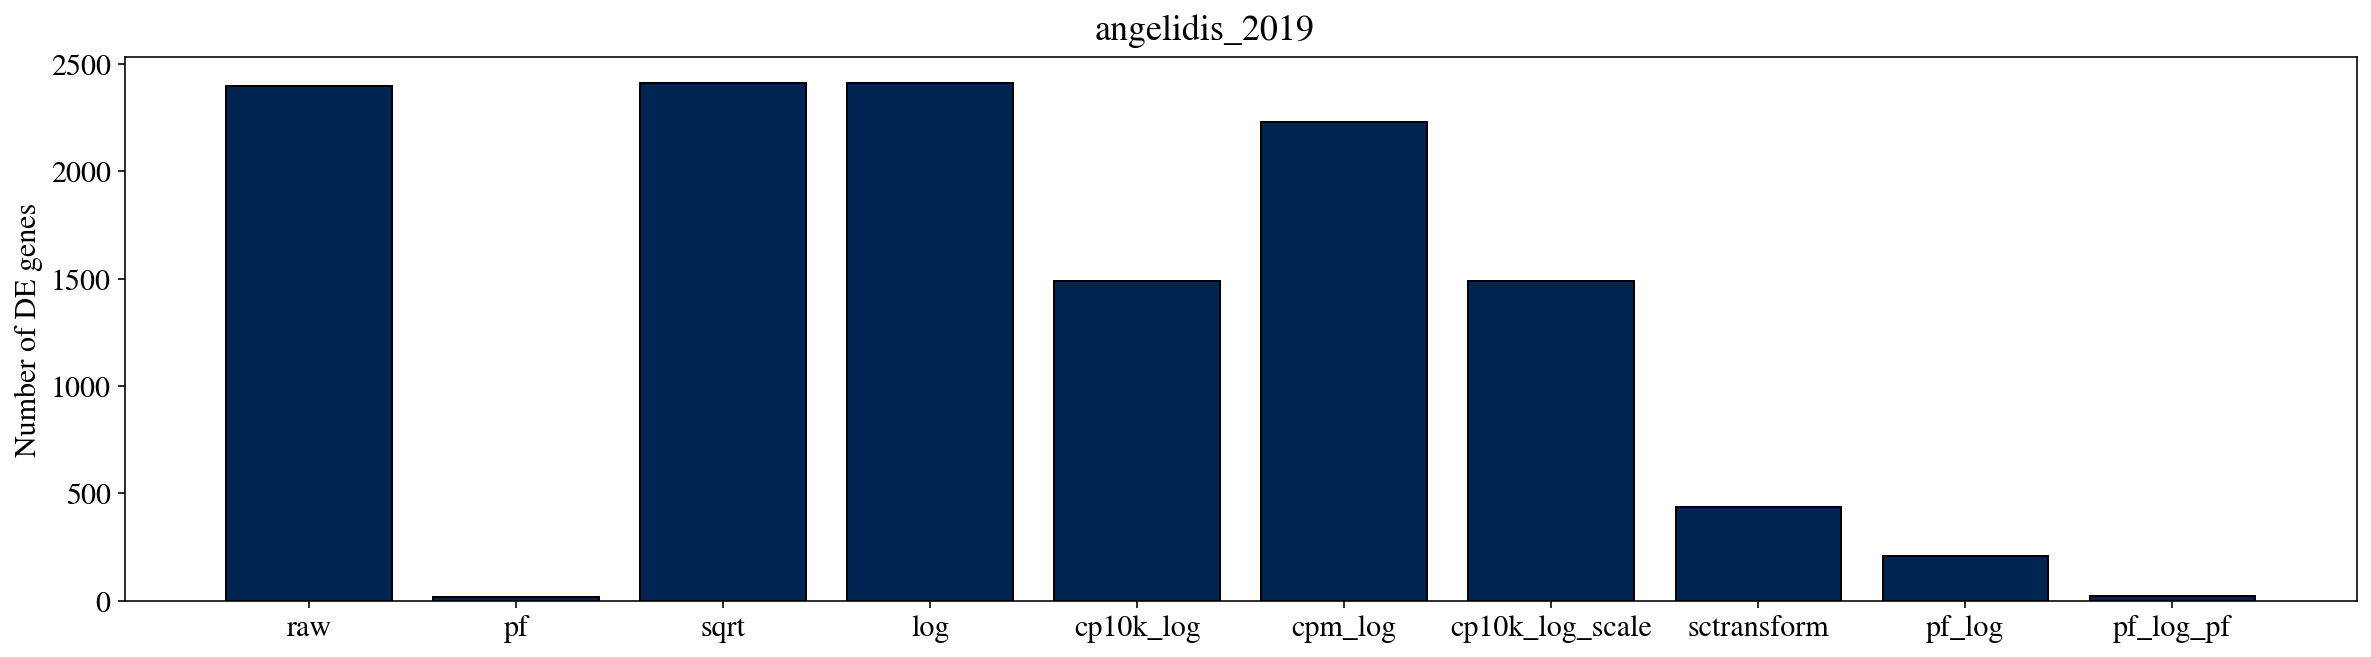

In [995]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle(ds, y=0.94)

x = [k for k,_ in res.items()]
y = [v.name.nunique() for k,v in res.items()]
ax.bar(x,y, facecolor=colors["cell"], edgecolor="k")
ax.set(**{
    "ylabel": "Number of DE genes",

})

fig.savefig(f"{ds}_depth_DE_genes.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# Cell depth and clustering

In [255]:
from sklearn.metrics import pairwise_distances

In [996]:
depth = pairwise_distances(data["raw"][ct_mask].sum(1).reshape(-1,1), metric="l1")
depth = depth[np.triu_indices(depth.shape[0], k = 1)]
depth_mask = depth > 500

depth = depth[depth_mask]

In [997]:
%%time
dist = {}
for l in labels:
    print(l)
    pw = pairwise_distances(data[l][ct_mask], metric="l1")
    v = pw[np.triu_indices(pw.shape[0], k = 1)]
    dist[l] = v[depth_mask]

raw
pf
sqrt
log
cp10k_log
cpm_log
cp10k_log_scale
sctransform
pf_log
pf_log_pf
CPU times: user 32min 20s, sys: 11.4 s, total: 32min 31s
Wall time: 32min 31s


In [1098]:
for l in labels:
    x = depth
    y = dist[l]
    r,p = stats.pearsonr(x,y)
    ct_metrics[l]["depth_distance"] = r

In [ ]:
didx = np.random.choice(depth.shape[0], size=10000, replace=False)

In [2]:
didx

NameError: name 'didx' is not defined

In [1258]:
plot_labels = ["raw", "pf_log_pf", "cp10k_log_scale", "sctransform"]

fig, axs = plt.subplots(figsize=(10,10), nrows=5, ncols=2)
fig.suptitle(ds, y=0.94)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for ax, l in zip(fig.axes, labels):
    x = depth
    y = dist[l]
    r,p = stats.pearsonr(x,y)
    ax.scatter(x,y, alpha=0.01, facecolor=colors["cell"])
    reg = LinearRegression().fit(x.reshape(-1,1), y)

    xx = np.array([min(x), max(x)])
    ax.plot(xx, reg.coef_*xx+ reg.intercept_, color="darkgray", linestyle="--", linewidth=3, label=f"r: {r:,.2f}")

    ax.set(**{
        "xlabel": "Difference in depth",
        "ylabel": "Pairwise distance",
        "title": l,
    })
    ax.legend()
#fig.savefig(f"{ds}_dist_depth.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

08-Mar-22 01:23:17 - /home/sina/bin/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)



Error in callback <function flush_figures at 0x7ff96a908680> (for post_execute):


KeyboardInterrupt: 

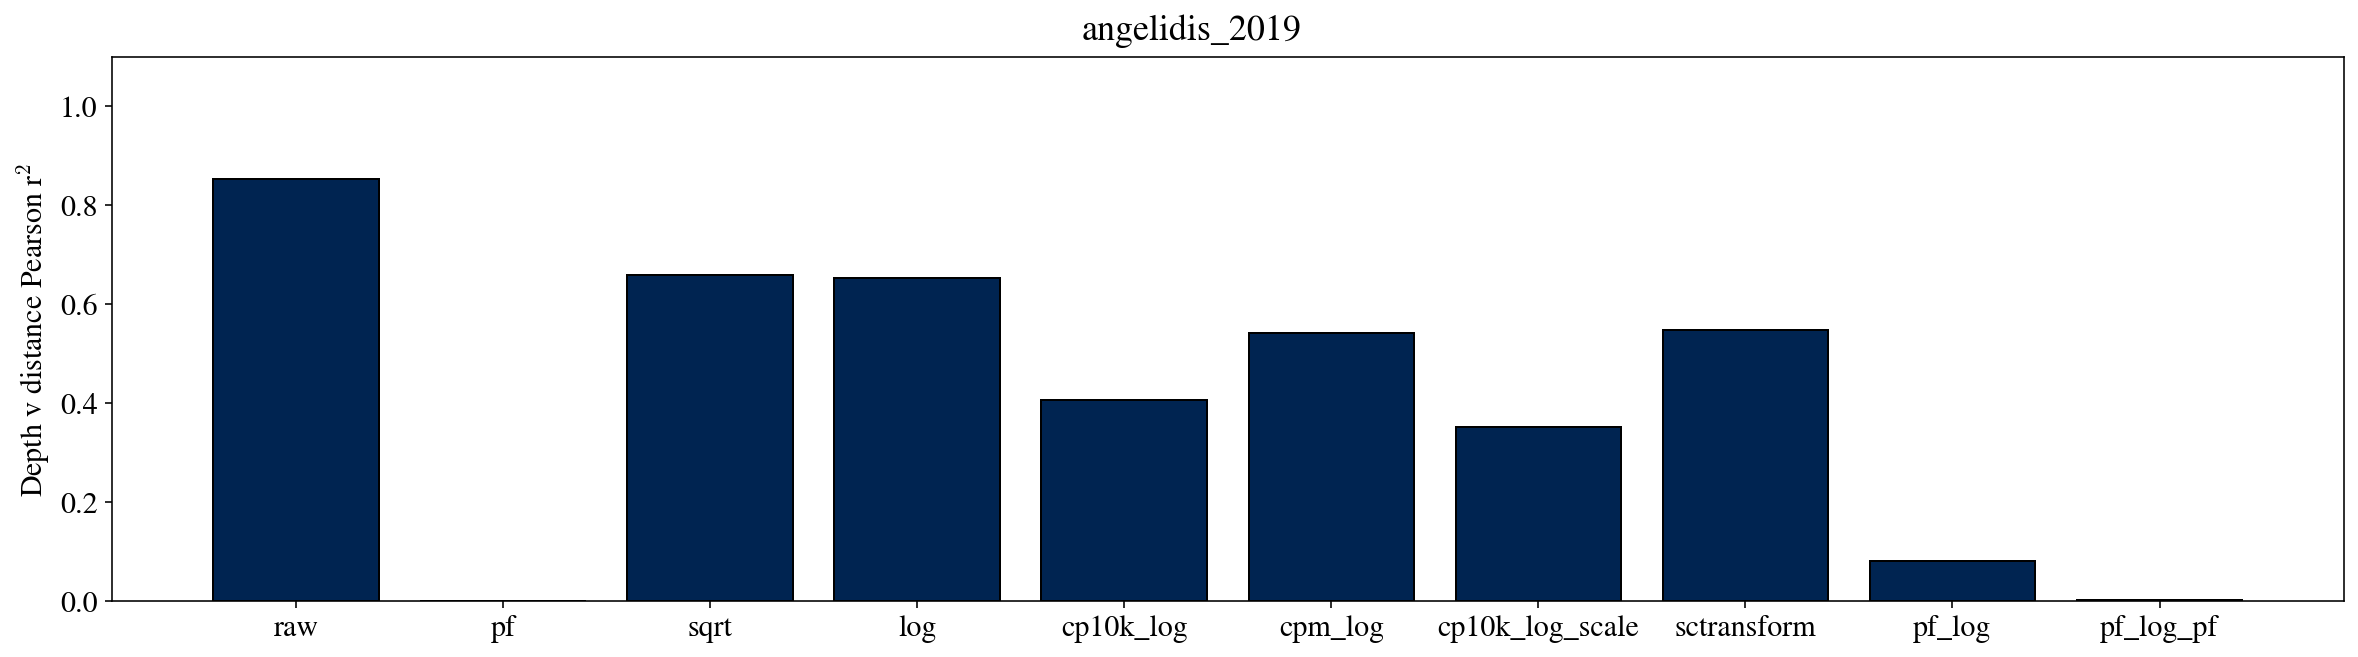

In [1103]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle(ds, y=0.94)

x = [k for k,_ in ct_metrics.items()]
y = np.array([v["depth_distance"] for k,v in ct_metrics.items()])
ax.bar(x,y**2, facecolor=colors["cell"], edgecolor="k")
ax.set(**{
    "ylabel": "Depth v distance Pearson r$^2$",
    "ylim": (0, 1.1)

})

#fig.savefig(f"{ds}_depth_DE_genes.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")

fig.show()

# Celltype specific figure

In [1010]:
for k, v in data.items():
    ct_metrics[k]["mono"] = stats.spearmanr(v[ct_mask].mean(0), data["raw"][ct_mask].mean(0)).correlation

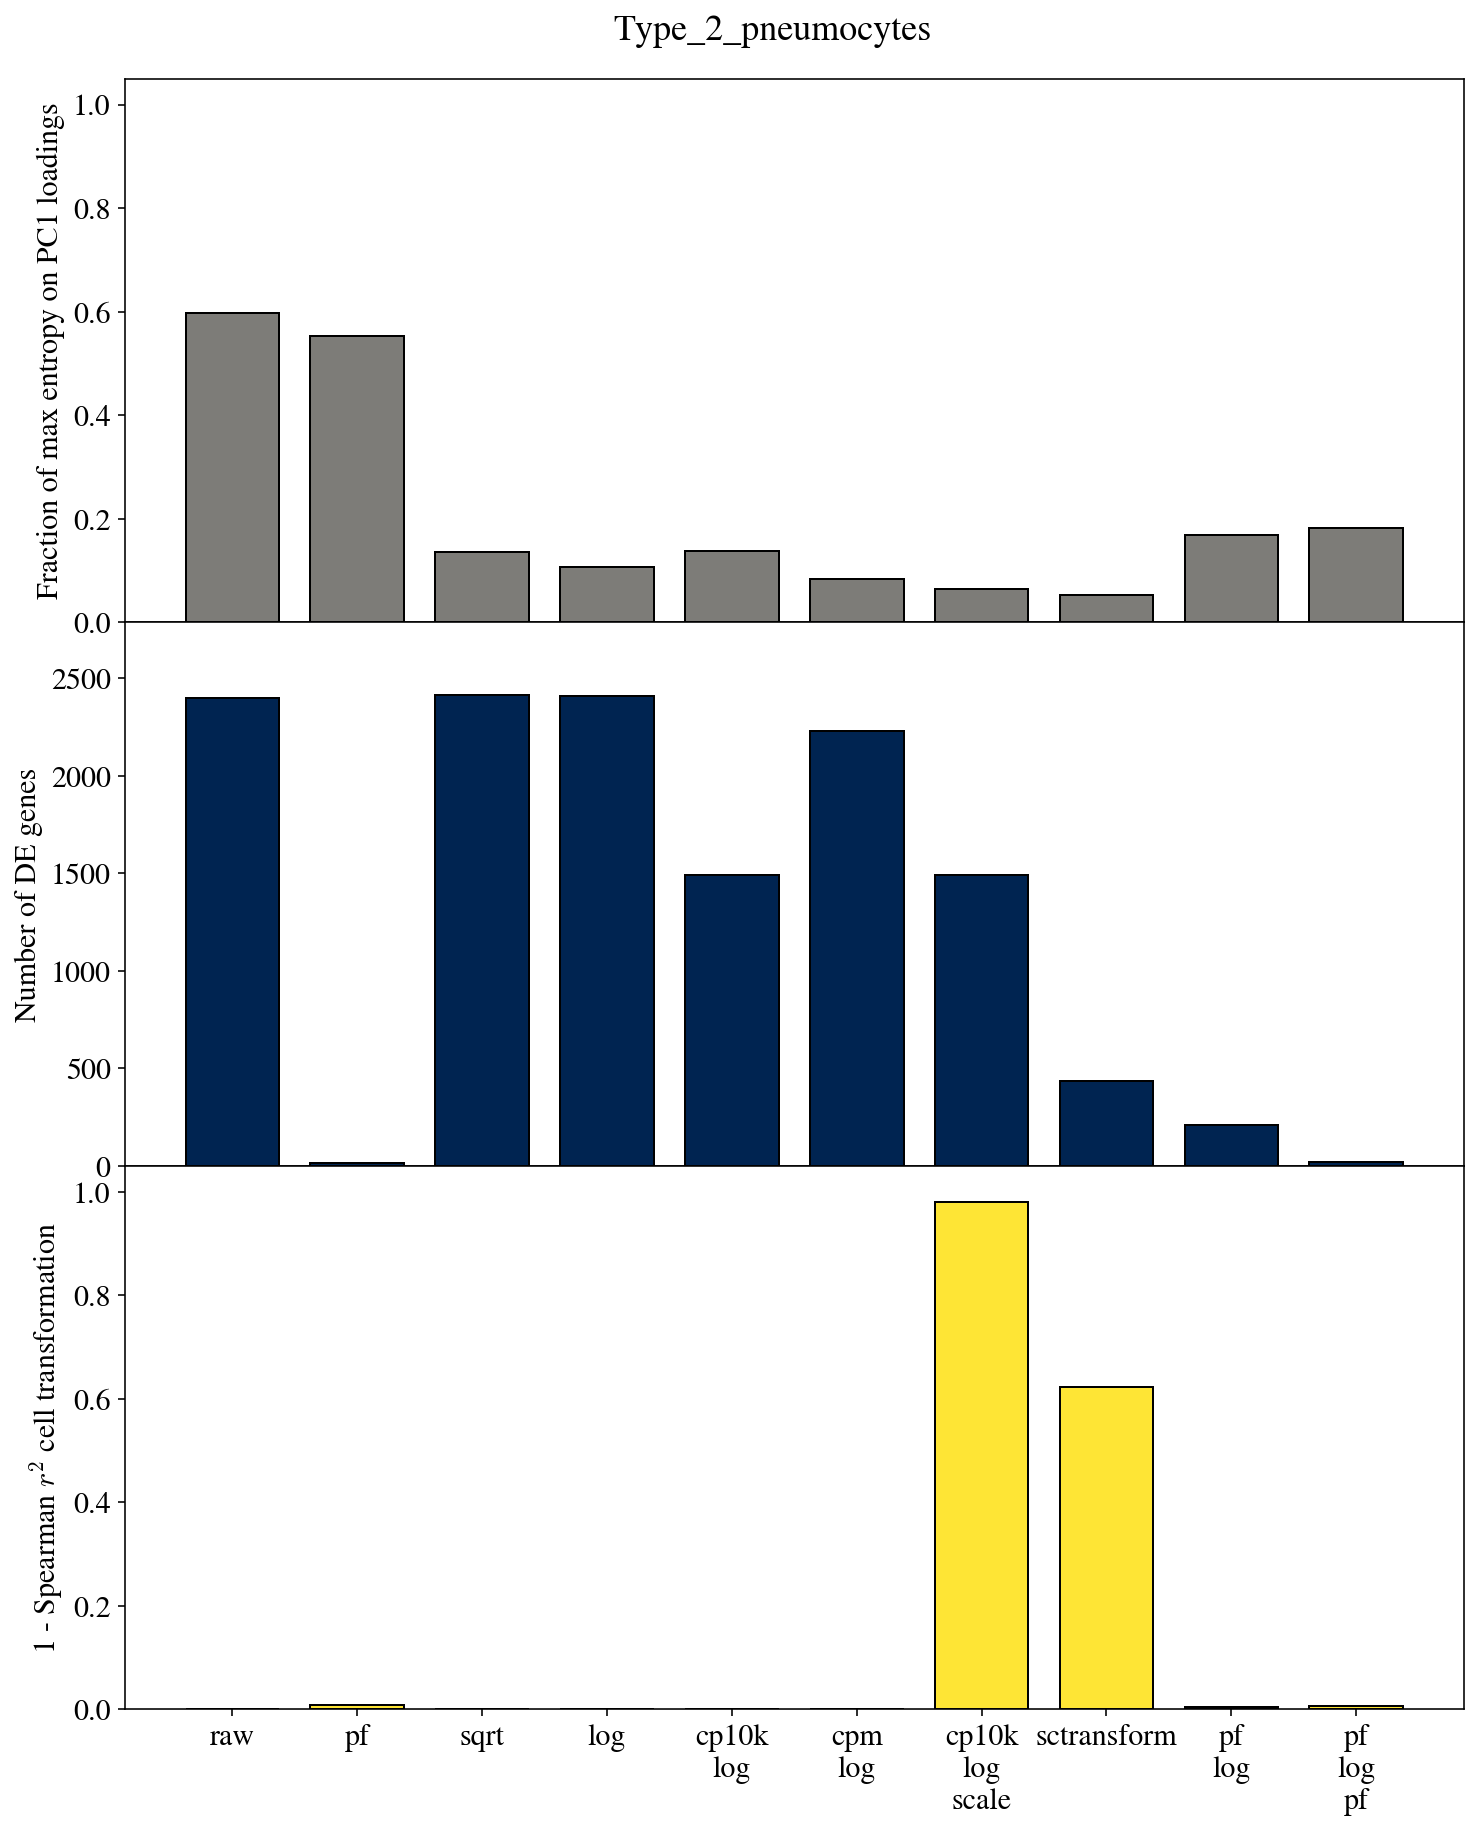

In [1012]:
nr=3

fig, axs = plt.subplots(figsize=(12,5*nr), nrows=nr)
fig.suptitle(ct, y=0.91)
fig.subplots_adjust(hspace=0)

x = ["\n".join(i.split("_")) for i in labels]
xx = np.arange(len(labels))  # the label locations
width = 0.75  # the width of the bars

p = {
    "xticks": [],
    "xticklabels": []

}

##################
ax = axs[0]

maxent = -np.log(1/data["raw"].shape[1])

y = np.array([ct_metrics[i]["pc_entropy"] for i in labels])
ax.bar(xx, (maxent - y)/maxent, width, label='PC entropy', edgecolor="k", color=colors["gene"])

p.update({
    "ylim": (0, 1.05),
    "ylabel": "Fraction of max entropy on PC1 loadings"
})

ax.set(**p)

##################
ax = axs[1]

y = np.array([ct_metrics[i]["de_genes"] for i in labels])
ax.bar(xx, y, width, label='False positive DE genes', edgecolor="k", color=colors["cell"])

p.update({
    "ylim": (0, ax.get_ylim()[1]*1.1),
    "ylabel": "Number of DE genes",
})

ax.set(**p)


##################
ax = axs[2]

y = np.array([ct_metrics[i]["mono"] for i in labels])
ax.bar(xx, 1-y**2, width, label='pairwise_sp', edgecolor="k", color=colors["mono"])

p.update({
    "ylabel": "1 - Spearman $r^2$ cell transformation",
    "yscale": "linear",
    "xticks": xx,
    "xticklabels": x,
    "ylim": (0, 1.05),
})

ax.set(**p)

fig.savefig(f"{ds}_celltype_metrics.png", facecolor='white', transparent=False, dpi=300, bbox_inches="tight")
fig.show()